The following code defines LSTM model setup trained on visual modality data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

2022-05-28 10:54:16.711599: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import sys
sys.path.insert(1, '../')

from data_preparation import prepare_x_data, get_Y_labels, reshape_Y, reshape_X, unscale_Y

In [4]:
scaler = StandardScaler()

## Data preparation

Data preparation includes: <br>
<ul>
  <li>selecting necessary features from source files</li>
  <li>creating combined dataset for the model training</li>
  <li>reshaping data for model training.</li>


### X data - visual features

In [5]:
x_train = prepare_x_data('../Data/LLDs_video_openface/train',',', 5, scaler)

In [6]:
x_test = prepare_x_data('../Data/LLDs_video_openface/dev',',', 5, scaler) 

### Y data - YMRS score

In [7]:
y_train = get_Y_labels('../Data/labels_metadata.csv', 60, 164, scaler)
y_train = reshape_Y(y_train,len(x_train),1,1)

In [8]:
y_test = get_Y_labels('../Data/labels_metadata.csv', 0, 60, scaler)
y_test = reshape_Y(y_test,len(x_test),1,1)

## Model setup - LSTM

Proposed model for LSTM recurrent neural network architecture.

### Defining the model

In [9]:
model = keras.Sequential()

2022-05-28 10:54:54.568047: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-28 10:54:54.575558: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-28 10:54:56.145347: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-28 10:54:56.149317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2022-05-28 10:54:56.149404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-28 10:54:56.150414: I tensorflow/stream_executor/plat

In [10]:
model.add(layers.LSTM(units = 206, input_shape=(None,465), return_sequences=True))
model.add(layers.Dropout(0.004))
model.add(layers.LSTM(units = 206, input_shape=(None,206), return_sequences=False))
model.add(layers.Dropout(0.004))
model.add(layers.Dense(1, activation='linear'))

In [11]:
model.compile(
    loss="mse", 
    metrics= [keras.metrics.MeanAbsoluteError()], #['mean_absolute_error'],  
    optimizer=keras.optimizers.Adam(learning_rate=0.003)
    )

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 206)         553728    
_________________________________________________________________
dropout (Dropout)            (None, None, 206)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 206)               340312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 206)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 207       
Total params: 894,247
Trainable params: 894,247
Non-trainable params: 0
_________________________________________________________________


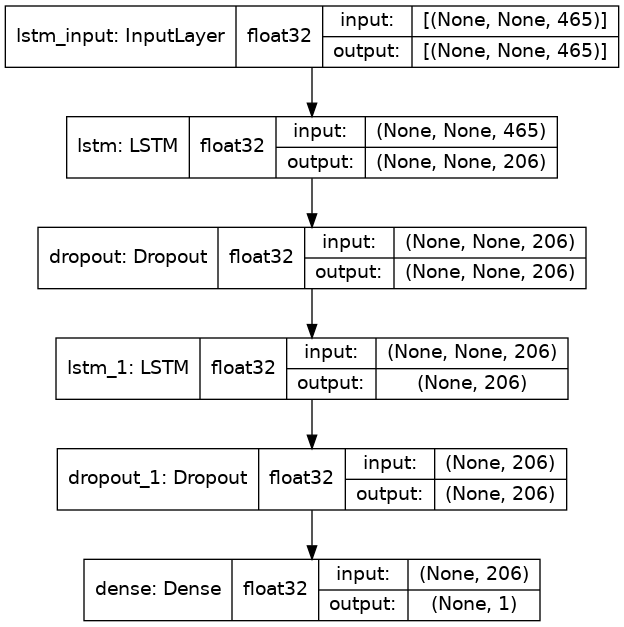

In [13]:
keras.utils.plot_model(model=model, show_dtype=True, show_layer_names=True, show_shapes=True, to_file='LSTM_unimodal_visual.png') # learning rate

### Model training

Model training setup is based on an iterative approach where model is trained one file at a time, then learned parameters are saved and loaded in the next iterative step. This setup is necessary due to the fact that source files does not have an uniform size and differ in number of frames.

In [14]:
train_index = 0

train_eval = []
train_loss = []
train_mae = []

for file in x_train:
        file = np.array(file).reshape((1, file.shape[0], -1))
        model.fit(x=file, 
                y=y_train[train_index], 
                epochs=10,
                batch_size = len(file))    
                
        scores = model.evaluate(file, y_train[train_index], verbose = 0)
        train_eval.append(scores)
        train_loss.append(scores[0])
        train_mae.append(scores[1])
                
        model.save(r'LSTM_train_visual', include_optimizer=True) # Save model configuration to Saved_models.
        model = keras.models.load_model(r'LSTM_train_visual') # Load model configuration from Saved_models.
                
        train_index += 1  

2022-05-28 10:54:57.739301: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-28 10:54:57.739779: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994365000 Hz


Epoch 1/10


2022-05-28 10:54:59.278512: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-28 10:54:59.518676: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1/1 [==============================] - 11s 11s/step - loss: 0.0686 - mean_absolute_error: 0.2619
Epoch 2/10
1/1 [==============================] - 0s 318ms/step - loss: 20.1710 - mean_absolute_error: 4.4912
Epoch 3/10
1/1 [==============================] - 0s 284ms/step - loss: 0.3378 - mean_absolute_error: 0.5812
Epoch 4/10
1/1 [==============================] - 0s 295ms/step - loss: 3.8635 - mean_absolute_error: 1.9656
Epoch 5/10
1/1 [==============================] - 0s 304ms/step - loss: 1.6189 - mean_absolute_error: 1.2724
Epoch 6/10
1/1 [==============================] - 0s 266ms/step - loss: 0.2810 - mean_absolute_error: 0.5301
Epoch 7/10
1/1 [==============================] - 0s 291ms/step - loss: 0.0015 - mean_absolute_error: 0.0391
Epoch 8/10
1/1 [==============================] - 0s 274ms/step - loss: 0.1397 - mean_absolute_error: 0.3737
Epoch 9/10
1/1 [==============================] - 0s 274ms/step - loss: 0.2640 - mean_absolute_error: 0.5138
Epoch 10/10
1/1 [=============

2022-05-28 10:55:14.488569: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.0646 - mean_absolute_error: 1.0318
Epoch 2/10
1/1 [==============================] - 0s 283ms/step - loss: 0.1135 - mean_absolute_error: 0.3369
Epoch 3/10
1/1 [==============================] - 0s 289ms/step - loss: 0.1185 - mean_absolute_error: 0.3443
Epoch 4/10
1/1 [==============================] - 0s 284ms/step - loss: 0.0109 - mean_absolute_error: 0.1042
Epoch 5/10
1/1 [==============================] - 0s 285ms/step - loss: 0.0296 - mean_absolute_error: 0.1720
Epoch 6/10
1/1 [==============================] - 0s 281ms/step - loss: 0.0485 - mean_absolute_error: 0.2202
Epoch 7/10
1/1 [==============================] - 0s 297ms/step - loss: 0.0288 - mean_absolute_error: 0.1698
Epoch 8/10
1/1 [==============================] - 0s 306ms/step - loss: 0.0057 - mean_absolute_error: 0.0752
Epoch 9/10
1/1 [==============================] - 0s 308ms/step - loss: 0.0011 - mean_absolute_error: 0.0326
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 3.0087 - mean_absolute_error: 1.7346
Epoch 2/10
1/1 [==============================] - 0s 300ms/step - loss: 1.7946 - mean_absolute_error: 1.3396
Epoch 3/10
1/1 [==============================] - 0s 308ms/step - loss: 0.2057 - mean_absolute_error: 0.4536
Epoch 4/10
1/1 [==============================] - 0s 304ms/step - loss: 0.0132 - mean_absolute_error: 0.1149
Epoch 5/10
1/1 [==============================] - 0s 300ms/step - loss: 0.0185 - mean_absolute_error: 0.1361
Epoch 6/10
1/1 [==============================] - 0s 329ms/step - loss: 0.0229 - mean_absolute_error: 0.1514
Epoch 7/10
1/1 [==============================] - 0s 302ms/step - loss: 0.0173 - mean_absolute_error: 0.1316
Epoch 8/10
1/1 [==============================] - 0s 303ms/step - loss: 0.0099 - mean_absolute_error: 0.0995
Epoch 9/10
1/1 [==============================] - 0s 329ms/step - loss: 0.0280 - mean_absolute_error: 0.1672
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1032 - mean_absolute_error: 0.3212
Epoch 2/10
1/1 [==============================] - 0s 249ms/step - loss: 4.2226 - mean_absolute_error: 2.0549
Epoch 3/10
1/1 [==============================] - 0s 262ms/step - loss: 0.0039 - mean_absolute_error: 0.0628
Epoch 4/10
1/1 [==============================] - 0s 246ms/step - loss: 2.0891 - mean_absolute_error: 1.4454
Epoch 5/10
1/1 [==============================] - 0s 247ms/step - loss: 0.1074 - mean_absolute_error: 0.3278
Epoch 6/10
1/1 [==============================] - 0s 261ms/step - loss: 0.1497 - mean_absolute_error: 0.3870
Epoch 7/10
1/1 [==============================] - 0s 248ms/step - loss: 0.1564 - mean_absolute_error: 0.3955
Epoch 8/10
1/1 [==============================] - 0s 271ms/step - loss: 0.0031 - mean_absolute_error: 0.0558
Epoch 9/10
1/1 [==============================] - 0s 247ms/step - loss: 0.0906 - mean_absolute_error: 0.3010
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1505 - mean_absolute_error: 0.3879
Epoch 2/10
1/1 [==============================] - 0s 111ms/step - loss: 1.9827 - mean_absolute_error: 1.4081
Epoch 3/10
1/1 [==============================] - 0s 106ms/step - loss: 0.0935 - mean_absolute_error: 0.3058
Epoch 4/10
1/1 [==============================] - 0s 91ms/step - loss: 0.5390 - mean_absolute_error: 0.7342
Epoch 5/10
1/1 [==============================] - 0s 92ms/step - loss: 0.4953 - mean_absolute_error: 0.7038
Epoch 6/10
1/1 [==============================] - 0s 91ms/step - loss: 0.1561 - mean_absolute_error: 0.3950
Epoch 7/10
1/1 [==============================] - 0s 90ms/step - loss: 0.0055 - mean_absolute_error: 0.0740
Epoch 8/10
1/1 [==============================] - 0s 100ms/step - loss: 0.0483 - mean_absolute_error: 0.2197
Epoch 9/10
1/1 [==============================] - 0s 94ms/step - loss: 0.1415 - mean_absolute_error: 0.3762
Epoch 10/10
1/1 [==========

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.0239 - mean_absolute_error: 1.0119
Epoch 2/10
1/1 [==============================] - 0s 282ms/step - loss: 0.0699 - mean_absolute_error: 0.2644
Epoch 3/10
1/1 [==============================] - 0s 310ms/step - loss: 0.1565 - mean_absolute_error: 0.3956
Epoch 4/10
1/1 [==============================] - 0s 320ms/step - loss: 0.0246 - mean_absolute_error: 0.1570
Epoch 5/10
1/1 [==============================] - 0s 288ms/step - loss: 0.0026 - mean_absolute_error: 0.0506
Epoch 6/10
1/1 [==============================] - 0s 280ms/step - loss: 0.0103 - mean_absolute_error: 0.1016
Epoch 7/10
1/1 [==============================] - 0s 304ms/step - loss: 0.0063 - mean_absolute_error: 0.0794
Epoch 8/10
1/1 [==============================] - 0s 281ms/step - loss: 1.0169e-04 - mean_absolute_error: 0.0101
Epoch 9/10
1/1 [==============================] - 0s 338ms/step - loss: 0.0142 - mean_absolute_error: 0.1190
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.5337 - mean_absolute_error: 1.5917
Epoch 2/10
1/1 [==============================] - 0s 246ms/step - loss: 1.0946 - mean_absolute_error: 1.0463
Epoch 3/10
1/1 [==============================] - 0s 202ms/step - loss: 0.2731 - mean_absolute_error: 0.5226
Epoch 4/10
1/1 [==============================] - 0s 204ms/step - loss: 0.0180 - mean_absolute_error: 0.1341
Epoch 5/10
1/1 [==============================] - 0s 207ms/step - loss: 0.3112 - mean_absolute_error: 0.5578
Epoch 6/10
1/1 [==============================] - 0s 202ms/step - loss: 0.1587 - mean_absolute_error: 0.3984
Epoch 7/10
1/1 [==============================] - 0s 214ms/step - loss: 0.0386 - mean_absolute_error: 0.1964
Epoch 8/10
1/1 [==============================] - 0s 202ms/step - loss: 0.0024 - mean_absolute_error: 0.0494
Epoch 9/10
1/1 [==============================] - 0s 201ms/step - loss: 0.0089 - mean_absolute_error: 0.0946
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.0398 - mean_absolute_error: 1.4282
Epoch 2/10
1/1 [==============================] - 0s 143ms/step - loss: 1.5581 - mean_absolute_error: 1.2482
Epoch 3/10
1/1 [==============================] - 0s 143ms/step - loss: 0.0686 - mean_absolute_error: 0.2619
Epoch 4/10
1/1 [==============================] - 0s 143ms/step - loss: 0.2673 - mean_absolute_error: 0.5170
Epoch 5/10
1/1 [==============================] - 0s 143ms/step - loss: 0.3946 - mean_absolute_error: 0.6282
Epoch 6/10
1/1 [==============================] - 0s 148ms/step - loss: 0.1988 - mean_absolute_error: 0.4459
Epoch 7/10
1/1 [==============================] - 0s 158ms/step - loss: 0.0227 - mean_absolute_error: 0.1508
Epoch 8/10
1/1 [==============================] - 0s 143ms/step - loss: 0.0936 - mean_absolute_error: 0.3060
Epoch 9/10
1/1 [==============================] - 0s 160ms/step - loss: 0.1595 - mean_absolute_error: 0.3994
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 8.7811 - mean_absolute_error: 2.9633
Epoch 2/10
1/1 [==============================] - 0s 160ms/step - loss: 5.7067 - mean_absolute_error: 2.3889
Epoch 3/10
1/1 [==============================] - 0s 140ms/step - loss: 3.4616 - mean_absolute_error: 1.8605
Epoch 4/10
1/1 [==============================] - 0s 140ms/step - loss: 2.1965 - mean_absolute_error: 1.4821
Epoch 5/10
1/1 [==============================] - 0s 147ms/step - loss: 0.9736 - mean_absolute_error: 0.9867
Epoch 6/10
1/1 [==============================] - 0s 154ms/step - loss: 0.3053 - mean_absolute_error: 0.5525
Epoch 7/10
1/1 [==============================] - 0s 153ms/step - loss: 0.0260 - mean_absolute_error: 0.1613
Epoch 8/10
1/1 [==============================] - 0s 140ms/step - loss: 0.2307 - mean_absolute_error: 0.4803
Epoch 9/10
1/1 [==============================] - 0s 139ms/step - loss: 0.3230 - mean_absolute_error: 0.5683
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 4.8940 - mean_absolute_error: 2.2122
Epoch 2/10
1/1 [==============================] - 0s 158ms/step - loss: 4.2393 - mean_absolute_error: 2.0590
Epoch 3/10
1/1 [==============================] - 0s 140ms/step - loss: 1.5063 - mean_absolute_error: 1.2273
Epoch 4/10
1/1 [==============================] - 0s 140ms/step - loss: 0.0154 - mean_absolute_error: 0.1243
Epoch 5/10
1/1 [==============================] - 0s 150ms/step - loss: 0.2431 - mean_absolute_error: 0.4931
Epoch 6/10
1/1 [==============================] - 0s 139ms/step - loss: 0.0701 - mean_absolute_error: 0.2648
Epoch 7/10
1/1 [==============================] - 0s 154ms/step - loss: 0.0961 - mean_absolute_error: 0.3100
Epoch 8/10
1/1 [==============================] - 0s 140ms/step - loss: 0.0049 - mean_absolute_error: 0.0699
Epoch 9/10
1/1 [==============================] - 0s 139ms/step - loss: 0.0358 - mean_absolute_error: 0.1891
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.8215 - mean_absolute_error: 0.9064
Epoch 2/10
1/1 [==============================] - 0s 170ms/step - loss: 0.1100 - mean_absolute_error: 0.3316
Epoch 3/10
1/1 [==============================] - 0s 151ms/step - loss: 0.0515 - mean_absolute_error: 0.2270
Epoch 4/10
1/1 [==============================] - 0s 150ms/step - loss: 0.0012 - mean_absolute_error: 0.0347
Epoch 5/10
1/1 [==============================] - 0s 150ms/step - loss: 0.0434 - mean_absolute_error: 0.2083
Epoch 6/10
1/1 [==============================] - 0s 166ms/step - loss: 0.0034 - mean_absolute_error: 0.0587
Epoch 7/10
1/1 [==============================] - 0s 152ms/step - loss: 0.0266 - mean_absolute_error: 0.1631
Epoch 8/10
1/1 [==============================] - 0s 164ms/step - loss: 0.0198 - mean_absolute_error: 0.1408
Epoch 9/10
1/1 [==============================] - 0s 152ms/step - loss: 0.0106 - mean_absolute_error: 0.1027
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.5455 - mean_absolute_error: 1.2432
Epoch 2/10
1/1 [==============================] - 0s 260ms/step - loss: 0.5595 - mean_absolute_error: 0.7480
Epoch 3/10
1/1 [==============================] - 0s 269ms/step - loss: 0.1378 - mean_absolute_error: 0.3712
Epoch 4/10
1/1 [==============================] - 0s 236ms/step - loss: 1.8583e-04 - mean_absolute_error: 0.0136
Epoch 5/10
1/1 [==============================] - 0s 235ms/step - loss: 0.0363 - mean_absolute_error: 0.1906
Epoch 6/10
1/1 [==============================] - 0s 234ms/step - loss: 0.1242 - mean_absolute_error: 0.3524
Epoch 7/10
1/1 [==============================] - 0s 234ms/step - loss: 0.0821 - mean_absolute_error: 0.2865
Epoch 8/10
1/1 [==============================] - 0s 234ms/step - loss: 0.0782 - mean_absolute_error: 0.2797
Epoch 9/10
1/1 [==============================] - 0s 235ms/step - loss: 0.0412 - mean_absolute_error: 0.2030
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5517 - mean_absolute_error: 0.7427
Epoch 2/10
1/1 [==============================] - 0s 183ms/step - loss: 0.0313 - mean_absolute_error: 0.1770
Epoch 3/10
1/1 [==============================] - 0s 172ms/step - loss: 0.2361 - mean_absolute_error: 0.4859
Epoch 4/10
1/1 [==============================] - 0s 189ms/step - loss: 0.0143 - mean_absolute_error: 0.1197
Epoch 5/10
1/1 [==============================] - 0s 171ms/step - loss: 0.0086 - mean_absolute_error: 0.0926
Epoch 6/10
1/1 [==============================] - 0s 171ms/step - loss: 0.0483 - mean_absolute_error: 0.2198
Epoch 7/10
1/1 [==============================] - 0s 171ms/step - loss: 9.8802e-05 - mean_absolute_error: 0.0099
Epoch 8/10
1/1 [==============================] - 0s 209ms/step - loss: 9.2657e-04 - mean_absolute_error: 0.0304
Epoch 9/10
1/1 [==============================] - 0s 171ms/step - loss: 0.0045 - mean_absolute_error: 0.0671
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 3.7730 - mean_absolute_error: 1.9424
Epoch 2/10
1/1 [==============================] - 0s 148ms/step - loss: 0.9531 - mean_absolute_error: 0.9763
Epoch 3/10
1/1 [==============================] - 0s 134ms/step - loss: 0.0494 - mean_absolute_error: 0.2222
Epoch 4/10
1/1 [==============================] - 0s 139ms/step - loss: 0.1675 - mean_absolute_error: 0.4092
Epoch 5/10
1/1 [==============================] - 0s 136ms/step - loss: 0.2070 - mean_absolute_error: 0.4550
Epoch 6/10
1/1 [==============================] - 0s 140ms/step - loss: 0.1360 - mean_absolute_error: 0.3688
Epoch 7/10
1/1 [==============================] - 0s 134ms/step - loss: 0.0626 - mean_absolute_error: 0.2503
Epoch 8/10
1/1 [==============================] - 0s 135ms/step - loss: 0.0031 - mean_absolute_error: 0.0555
Epoch 9/10
1/1 [==============================] - 0s 169ms/step - loss: 0.0069 - mean_absolute_error: 0.0830
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1016 - mean_absolute_error: 0.3188
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 0.0299 - mean_absolute_error: 0.1729
Epoch 3/10
1/1 [==============================] - 0s 61ms/step - loss: 0.0064 - mean_absolute_error: 0.0802
Epoch 4/10
1/1 [==============================] - 0s 56ms/step - loss: 1.7554e-04 - mean_absolute_error: 0.0132
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.0036 - mean_absolute_error: 0.0601
Epoch 6/10
1/1 [==============================] - 0s 51ms/step - loss: 0.0011 - mean_absolute_error: 0.0335
Epoch 7/10
1/1 [==============================] - 0s 50ms/step - loss: 0.0056 - mean_absolute_error: 0.0750
Epoch 8/10
1/1 [==============================] - 0s 50ms/step - loss: 3.8627e-04 - mean_absolute_error: 0.0197
Epoch 9/10
1/1 [==============================] - 0s 50ms/step - loss: 6.2221e-04 - mean_absolute_error: 0.0249
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.2688 - mean_absolute_error: 1.1264
Epoch 2/10
1/1 [==============================] - 0s 149ms/step - loss: 0.2347 - mean_absolute_error: 0.4844
Epoch 3/10
1/1 [==============================] - 0s 144ms/step - loss: 0.0762 - mean_absolute_error: 0.2760
Epoch 4/10
1/1 [==============================] - 0s 144ms/step - loss: 0.0155 - mean_absolute_error: 0.1246
Epoch 5/10
1/1 [==============================] - 0s 142ms/step - loss: 6.6316e-04 - mean_absolute_error: 0.0258
Epoch 6/10
1/1 [==============================] - 0s 150ms/step - loss: 0.0170 - mean_absolute_error: 0.1303
Epoch 7/10
1/1 [==============================] - 0s 143ms/step - loss: 0.0266 - mean_absolute_error: 0.1632
Epoch 8/10
1/1 [==============================] - 0s 143ms/step - loss: 0.0198 - mean_absolute_error: 0.1407
Epoch 9/10
1/1 [==============================] - 0s 144ms/step - loss: 0.0076 - mean_absolute_error: 0.0874
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 7.6331 - mean_absolute_error: 2.7628
Epoch 2/10
1/1 [==============================] - 1s 989ms/step - loss: 5.7709 - mean_absolute_error: 2.4023
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 4.5995 - mean_absolute_error: 2.1446
Epoch 4/10
1/1 [==============================] - 1s 931ms/step - loss: 3.5071 - mean_absolute_error: 1.8727
Epoch 5/10
1/1 [==============================] - 1s 976ms/step - loss: 2.5006 - mean_absolute_error: 1.5813
Epoch 6/10
1/1 [==============================] - 1s 928ms/step - loss: 1.5850 - mean_absolute_error: 1.2590
Epoch 7/10
1/1 [==============================] - 1s 961ms/step - loss: 0.7796 - mean_absolute_error: 0.8829
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.1869 - mean_absolute_error: 0.4324
Epoch 9/10
1/1 [==============================] - 1s 981ms/step - loss: 0.0145 - mean_absolute_error: 0.1206
Epoch 10/10
1/1 [===========

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 7.2723 - mean_absolute_error: 2.6967
Epoch 2/10
1/1 [==============================] - 0s 259ms/step - loss: 2.2791 - mean_absolute_error: 1.5097
Epoch 3/10
1/1 [==============================] - 0s 229ms/step - loss: 0.5070 - mean_absolute_error: 0.7120
Epoch 4/10
1/1 [==============================] - 0s 234ms/step - loss: 0.0121 - mean_absolute_error: 0.1098
Epoch 5/10
1/1 [==============================] - 0s 232ms/step - loss: 0.2284 - mean_absolute_error: 0.4779
Epoch 6/10
1/1 [==============================] - 0s 232ms/step - loss: 0.2228 - mean_absolute_error: 0.4720
Epoch 7/10
1/1 [==============================] - 0s 231ms/step - loss: 0.2718 - mean_absolute_error: 0.5214
Epoch 8/10
1/1 [==============================] - 0s 255ms/step - loss: 0.2964 - mean_absolute_error: 0.5444
Epoch 9/10
1/1 [==============================] - 0s 252ms/step - loss: 0.1449 - mean_absolute_error: 0.3807
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0592 - mean_absolute_error: 0.2433
Epoch 2/10
1/1 [==============================] - 0s 265ms/step - loss: 0.2863 - mean_absolute_error: 0.5350
Epoch 3/10
1/1 [==============================] - 0s 266ms/step - loss: 0.0121 - mean_absolute_error: 0.1098
Epoch 4/10
1/1 [==============================] - 0s 289ms/step - loss: 0.0736 - mean_absolute_error: 0.2713
Epoch 5/10
1/1 [==============================] - 0s 266ms/step - loss: 0.0035 - mean_absolute_error: 0.0595
Epoch 6/10
1/1 [==============================] - 0s 325ms/step - loss: 0.0287 - mean_absolute_error: 0.1695
Epoch 7/10
1/1 [==============================] - 0s 266ms/step - loss: 0.0374 - mean_absolute_error: 0.1933
Epoch 8/10
1/1 [==============================] - 0s 293ms/step - loss: 0.0120 - mean_absolute_error: 0.1093
Epoch 9/10
1/1 [==============================] - 0s 272ms/step - loss: 0.0373 - mean_absolute_error: 0.1931
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.0081 - mean_absolute_error: 1.0040
Epoch 2/10
1/1 [==============================] - 0s 109ms/step - loss: 0.3061 - mean_absolute_error: 0.5533
Epoch 3/10
1/1 [==============================] - 0s 97ms/step - loss: 0.0054 - mean_absolute_error: 0.0736
Epoch 4/10
1/1 [==============================] - 0s 119ms/step - loss: 0.1397 - mean_absolute_error: 0.3738
Epoch 5/10
1/1 [==============================] - 0s 104ms/step - loss: 0.2170 - mean_absolute_error: 0.4659
Epoch 6/10
1/1 [==============================] - 0s 93ms/step - loss: 0.3381 - mean_absolute_error: 0.5814
Epoch 7/10
1/1 [==============================] - 0s 105ms/step - loss: 0.1701 - mean_absolute_error: 0.4124
Epoch 8/10
1/1 [==============================] - 0s 95ms/step - loss: 0.0765 - mean_absolute_error: 0.2766
Epoch 9/10
1/1 [==============================] - 0s 95ms/step - loss: 0.0065 - mean_absolute_error: 0.0804
Epoch 10/10
1/1 [=========

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.3178 - mean_absolute_error: 0.5637
Epoch 2/10
1/1 [==============================] - 1s 528ms/step - loss: 0.0037 - mean_absolute_error: 0.0608
Epoch 3/10
1/1 [==============================] - 1s 512ms/step - loss: 0.0471 - mean_absolute_error: 0.2169
Epoch 4/10
1/1 [==============================] - 0s 468ms/step - loss: 0.1567 - mean_absolute_error: 0.3959
Epoch 5/10
1/1 [==============================] - 1s 516ms/step - loss: 0.1902 - mean_absolute_error: 0.4361
Epoch 6/10
1/1 [==============================] - 0s 471ms/step - loss: 0.0131 - mean_absolute_error: 0.1147
Epoch 7/10
1/1 [==============================] - 0s 480ms/step - loss: 0.0190 - mean_absolute_error: 0.1377
Epoch 8/10
1/1 [==============================] - 1s 502ms/step - loss: 0.0887 - mean_absolute_error: 0.2978
Epoch 9/10
1/1 [==============================] - 0s 484ms/step - loss: 0.0863 - mean_absolute_error: 0.2938
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.3444 - mean_absolute_error: 1.1595
Epoch 2/10
1/1 [==============================] - 0s 172ms/step - loss: 0.5854 - mean_absolute_error: 0.7651
Epoch 3/10
1/1 [==============================] - 0s 159ms/step - loss: 0.1932 - mean_absolute_error: 0.4395
Epoch 4/10
1/1 [==============================] - 0s 164ms/step - loss: 0.0194 - mean_absolute_error: 0.1393
Epoch 5/10
1/1 [==============================] - 0s 158ms/step - loss: 0.0111 - mean_absolute_error: 0.1055
Epoch 6/10
1/1 [==============================] - 0s 176ms/step - loss: 0.0643 - mean_absolute_error: 0.2536
Epoch 7/10
1/1 [==============================] - 0s 185ms/step - loss: 0.0925 - mean_absolute_error: 0.3041
Epoch 8/10
1/1 [==============================] - 0s 175ms/step - loss: 0.0933 - mean_absolute_error: 0.3054
Epoch 9/10
1/1 [==============================] - 0s 158ms/step - loss: 0.0775 - mean_absolute_error: 0.2784
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.9265 - mean_absolute_error: 1.7107
Epoch 2/10
1/1 [==============================] - 0s 195ms/step - loss: 1.8475 - mean_absolute_error: 1.3592
Epoch 3/10
1/1 [==============================] - 0s 181ms/step - loss: 1.0301 - mean_absolute_error: 1.0149
Epoch 4/10
1/1 [==============================] - 0s 178ms/step - loss: 0.4683 - mean_absolute_error: 0.6843
Epoch 5/10
1/1 [==============================] - 0s 196ms/step - loss: 0.1082 - mean_absolute_error: 0.3290
Epoch 6/10
1/1 [==============================] - 0s 185ms/step - loss: 0.0063 - mean_absolute_error: 0.0797
Epoch 7/10
1/1 [==============================] - 0s 179ms/step - loss: 0.1438 - mean_absolute_error: 0.3792
Epoch 8/10
1/1 [==============================] - 0s 179ms/step - loss: 0.0874 - mean_absolute_error: 0.2957
Epoch 9/10
1/1 [==============================] - 0s 177ms/step - loss: 0.2188 - mean_absolute_error: 0.4678
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1084 - mean_absolute_error: 0.3293
Epoch 2/10
1/1 [==============================] - 0s 160ms/step - loss: 0.0629 - mean_absolute_error: 0.2507
Epoch 3/10
1/1 [==============================] - 0s 143ms/step - loss: 0.0748 - mean_absolute_error: 0.2735
Epoch 4/10
1/1 [==============================] - 0s 167ms/step - loss: 0.0015 - mean_absolute_error: 0.0392
Epoch 5/10
1/1 [==============================] - 0s 142ms/step - loss: 0.0024 - mean_absolute_error: 0.0494
Epoch 6/10
1/1 [==============================] - 0s 142ms/step - loss: 0.0189 - mean_absolute_error: 0.1376
Epoch 7/10
1/1 [==============================] - 0s 142ms/step - loss: 0.0159 - mean_absolute_error: 0.1263
Epoch 8/10
1/1 [==============================] - 0s 159ms/step - loss: 0.0013 - mean_absolute_error: 0.0361
Epoch 9/10
1/1 [==============================] - 0s 141ms/step - loss: 0.0035 - mean_absolute_error: 0.0593
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 5.2857 - mean_absolute_error: 2.2991
Epoch 2/10
1/1 [==============================] - 0s 263ms/step - loss: 3.6151 - mean_absolute_error: 1.9013
Epoch 3/10
1/1 [==============================] - 0s 266ms/step - loss: 2.5244 - mean_absolute_error: 1.5888
Epoch 4/10
1/1 [==============================] - 0s 265ms/step - loss: 1.7594 - mean_absolute_error: 1.3264
Epoch 5/10
1/1 [==============================] - 0s 265ms/step - loss: 0.8755 - mean_absolute_error: 0.9357
Epoch 6/10
1/1 [==============================] - 0s 266ms/step - loss: 0.6403 - mean_absolute_error: 0.8002
Epoch 7/10
1/1 [==============================] - 0s 271ms/step - loss: 0.3185 - mean_absolute_error: 0.5644
Epoch 8/10
1/1 [==============================] - 0s 290ms/step - loss: 0.1102 - mean_absolute_error: 0.3320
Epoch 9/10
1/1 [==============================] - 0s 264ms/step - loss: 0.0093 - mean_absolute_error: 0.0964
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.8603 - mean_absolute_error: 1.6913
Epoch 2/10
1/1 [==============================] - 1s 572ms/step - loss: 1.4020 - mean_absolute_error: 1.1840
Epoch 3/10
1/1 [==============================] - 1s 572ms/step - loss: 0.6140 - mean_absolute_error: 0.7836
Epoch 4/10
1/1 [==============================] - 1s 572ms/step - loss: 0.1283 - mean_absolute_error: 0.3582
Epoch 5/10
1/1 [==============================] - 1s 647ms/step - loss: 0.0032 - mean_absolute_error: 0.0565
Epoch 6/10
1/1 [==============================] - 1s 572ms/step - loss: 0.0018 - mean_absolute_error: 0.0421
Epoch 7/10
1/1 [==============================] - 1s 699ms/step - loss: 0.1026 - mean_absolute_error: 0.3203
Epoch 8/10
1/1 [==============================] - 1s 573ms/step - loss: 0.1755 - mean_absolute_error: 0.4189
Epoch 9/10
1/1 [==============================] - 1s 575ms/step - loss: 0.2228 - mean_absolute_error: 0.4720
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.7194 - mean_absolute_error: 1.3112
Epoch 2/10
1/1 [==============================] - 0s 248ms/step - loss: 0.8385 - mean_absolute_error: 0.9157
Epoch 3/10
1/1 [==============================] - 0s 239ms/step - loss: 0.2682 - mean_absolute_error: 0.5179
Epoch 4/10
1/1 [==============================] - 0s 241ms/step - loss: 0.0184 - mean_absolute_error: 0.1357
Epoch 5/10
1/1 [==============================] - 0s 261ms/step - loss: 0.0604 - mean_absolute_error: 0.2457
Epoch 6/10
1/1 [==============================] - 0s 247ms/step - loss: 0.0879 - mean_absolute_error: 0.2965
Epoch 7/10
1/1 [==============================] - 0s 243ms/step - loss: 0.0925 - mean_absolute_error: 0.3041
Epoch 8/10
1/1 [==============================] - 0s 242ms/step - loss: 0.0796 - mean_absolute_error: 0.2822
Epoch 9/10
1/1 [==============================] - 0s 275ms/step - loss: 0.0534 - mean_absolute_error: 0.2312
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0023 - mean_absolute_error: 0.0482
Epoch 2/10
1/1 [==============================] - 0s 282ms/step - loss: 0.1291 - mean_absolute_error: 0.3594
Epoch 3/10
1/1 [==============================] - 0s 283ms/step - loss: 0.0022 - mean_absolute_error: 0.0472
Epoch 4/10
1/1 [==============================] - 0s 285ms/step - loss: 0.0148 - mean_absolute_error: 0.1218
Epoch 5/10
1/1 [==============================] - 0s 278ms/step - loss: 0.0333 - mean_absolute_error: 0.1825
Epoch 6/10
1/1 [==============================] - 0s 292ms/step - loss: 0.0344 - mean_absolute_error: 0.1854
Epoch 7/10
1/1 [==============================] - 0s 285ms/step - loss: 0.0291 - mean_absolute_error: 0.1706
Epoch 8/10
1/1 [==============================] - 0s 283ms/step - loss: 0.0073 - mean_absolute_error: 0.0852
Epoch 9/10
1/1 [==============================] - 0s 282ms/step - loss: 4.7174e-04 - mean_absolute_error: 0.0217
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1733 - mean_absolute_error: 0.4163
Epoch 2/10
1/1 [==============================] - 0s 140ms/step - loss: 0.0119 - mean_absolute_error: 0.1092
Epoch 3/10
1/1 [==============================] - 0s 138ms/step - loss: 0.0658 - mean_absolute_error: 0.2566
Epoch 4/10
1/1 [==============================] - 0s 125ms/step - loss: 0.0408 - mean_absolute_error: 0.2020
Epoch 5/10
1/1 [==============================] - 0s 138ms/step - loss: 5.0344e-05 - mean_absolute_error: 0.0071
Epoch 6/10
1/1 [==============================] - 0s 127ms/step - loss: 3.6003e-04 - mean_absolute_error: 0.0190
Epoch 7/10
1/1 [==============================] - 0s 132ms/step - loss: 0.0073 - mean_absolute_error: 0.0855
Epoch 8/10
1/1 [==============================] - 0s 126ms/step - loss: 0.0119 - mean_absolute_error: 0.1091
Epoch 9/10
1/1 [==============================] - 0s 127ms/step - loss: 0.0086 - mean_absolute_error: 0.0928
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.3662 - mean_absolute_error: 0.6051
Epoch 2/10
1/1 [==============================] - 0s 302ms/step - loss: 0.0673 - mean_absolute_error: 0.2594
Epoch 3/10
1/1 [==============================] - 0s 303ms/step - loss: 8.2594e-04 - mean_absolute_error: 0.0287
Epoch 4/10
1/1 [==============================] - 0s 302ms/step - loss: 0.0424 - mean_absolute_error: 0.2059
Epoch 5/10
1/1 [==============================] - 0s 326ms/step - loss: 0.0508 - mean_absolute_error: 0.2254
Epoch 6/10
1/1 [==============================] - 0s 299ms/step - loss: 0.0162 - mean_absolute_error: 0.1274
Epoch 7/10
1/1 [==============================] - 0s 362ms/step - loss: 0.0061 - mean_absolute_error: 0.0782
Epoch 8/10
1/1 [==============================] - 0s 330ms/step - loss: 1.2549e-04 - mean_absolute_error: 0.0112
Epoch 9/10
1/1 [==============================] - 0s 356ms/step - loss: 0.0014 - mean_absolute_error: 0.0374
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.4808 - mean_absolute_error: 0.6934
Epoch 2/10
1/1 [==============================] - 0s 221ms/step - loss: 0.2340 - mean_absolute_error: 0.4837
Epoch 3/10
1/1 [==============================] - 0s 221ms/step - loss: 0.0921 - mean_absolute_error: 0.3034
Epoch 4/10
1/1 [==============================] - 0s 217ms/step - loss: 0.0243 - mean_absolute_error: 0.1560
Epoch 5/10
1/1 [==============================] - 0s 223ms/step - loss: 0.0010 - mean_absolute_error: 0.0318
Epoch 6/10
1/1 [==============================] - 0s 215ms/step - loss: 0.0072 - mean_absolute_error: 0.0847
Epoch 7/10
1/1 [==============================] - 0s 200ms/step - loss: 0.0165 - mean_absolute_error: 0.1285
Epoch 8/10
1/1 [==============================] - 0s 200ms/step - loss: 0.0272 - mean_absolute_error: 0.1650
Epoch 9/10
1/1 [==============================] - 0s 239ms/step - loss: 0.0286 - mean_absolute_error: 0.1691
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.4678 - mean_absolute_error: 1.2115
Epoch 2/10
1/1 [==============================] - 0s 141ms/step - loss: 0.4272 - mean_absolute_error: 0.6536
Epoch 3/10
1/1 [==============================] - 0s 119ms/step - loss: 0.0185 - mean_absolute_error: 0.1360
Epoch 4/10
1/1 [==============================] - 0s 119ms/step - loss: 0.0551 - mean_absolute_error: 0.2348
Epoch 5/10
1/1 [==============================] - 0s 155ms/step - loss: 0.1019 - mean_absolute_error: 0.3191
Epoch 6/10
1/1 [==============================] - 0s 121ms/step - loss: 0.1991 - mean_absolute_error: 0.4462
Epoch 7/10
1/1 [==============================] - 0s 122ms/step - loss: 0.1173 - mean_absolute_error: 0.3425
Epoch 8/10
1/1 [==============================] - 0s 118ms/step - loss: 0.0419 - mean_absolute_error: 0.2047
Epoch 9/10
1/1 [==============================] - 0s 140ms/step - loss: 0.0280 - mean_absolute_error: 0.1673
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1824 - mean_absolute_error: 0.4271
Epoch 2/10
1/1 [==============================] - 0s 182ms/step - loss: 9.9390e-05 - mean_absolute_error: 0.0100
Epoch 3/10
1/1 [==============================] - 0s 182ms/step - loss: 0.0447 - mean_absolute_error: 0.2115
Epoch 4/10
1/1 [==============================] - 0s 181ms/step - loss: 0.0278 - mean_absolute_error: 0.1668
Epoch 5/10
1/1 [==============================] - 0s 225ms/step - loss: 0.0019 - mean_absolute_error: 0.0436
Epoch 6/10
1/1 [==============================] - 0s 181ms/step - loss: 0.0032 - mean_absolute_error: 0.0567
Epoch 7/10
1/1 [==============================] - 0s 199ms/step - loss: 0.0077 - mean_absolute_error: 0.0878
Epoch 8/10
1/1 [==============================] - 0s 199ms/step - loss: 0.0041 - mean_absolute_error: 0.0639
Epoch 9/10
1/1 [==============================] - 0s 182ms/step - loss: 1.1101e-04 - mean_absolute_error: 0.0105
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0135 - mean_absolute_error: 0.1160
Epoch 2/10
1/1 [==============================] - 0s 374ms/step - loss: 0.0036 - mean_absolute_error: 0.0598
Epoch 3/10
1/1 [==============================] - 0s 341ms/step - loss: 0.0064 - mean_absolute_error: 0.0801
Epoch 4/10
1/1 [==============================] - 0s 340ms/step - loss: 0.0027 - mean_absolute_error: 0.0518
Epoch 5/10
1/1 [==============================] - 0s 412ms/step - loss: 8.6187e-05 - mean_absolute_error: 0.0093
Epoch 6/10
1/1 [==============================] - 0s 371ms/step - loss: 8.3819e-04 - mean_absolute_error: 0.0290
Epoch 7/10
1/1 [==============================] - 0s 388ms/step - loss: 0.0021 - mean_absolute_error: 0.0453
Epoch 8/10
1/1 [==============================] - 0s 371ms/step - loss: 0.0016 - mean_absolute_error: 0.0406
Epoch 9/10
1/1 [==============================] - 0s 338ms/step - loss: 0.0029 - mean_absolute_error: 0.0536
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.3674 - mean_absolute_error: 0.6061
Epoch 2/10
1/1 [==============================] - 1s 586ms/step - loss: 0.2352 - mean_absolute_error: 0.4849
Epoch 3/10
1/1 [==============================] - 1s 511ms/step - loss: 0.1394 - mean_absolute_error: 0.3733
Epoch 4/10
1/1 [==============================] - 1s 562ms/step - loss: 0.0684 - mean_absolute_error: 0.2616
Epoch 5/10
1/1 [==============================] - 1s 557ms/step - loss: 0.0234 - mean_absolute_error: 0.1531
Epoch 6/10
1/1 [==============================] - 1s 511ms/step - loss: 0.0015 - mean_absolute_error: 0.0382
Epoch 7/10
1/1 [==============================] - 1s 585ms/step - loss: 0.0054 - mean_absolute_error: 0.0734
Epoch 8/10
1/1 [==============================] - 1s 611ms/step - loss: 0.0254 - mean_absolute_error: 0.1595
Epoch 9/10
1/1 [==============================] - 1s 512ms/step - loss: 0.0169 - mean_absolute_error: 0.1301
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0101 - mean_absolute_error: 0.1007
Epoch 2/10
1/1 [==============================] - 0s 131ms/step - loss: 0.1254 - mean_absolute_error: 0.3541
Epoch 3/10
1/1 [==============================] - 0s 128ms/step - loss: 0.0093 - mean_absolute_error: 0.0965
Epoch 4/10
1/1 [==============================] - 0s 129ms/step - loss: 0.0098 - mean_absolute_error: 0.0988
Epoch 5/10
1/1 [==============================] - 0s 129ms/step - loss: 0.0287 - mean_absolute_error: 0.1693
Epoch 6/10
1/1 [==============================] - 0s 129ms/step - loss: 0.0314 - mean_absolute_error: 0.1773
Epoch 7/10
1/1 [==============================] - 0s 129ms/step - loss: 0.0106 - mean_absolute_error: 0.1027
Epoch 8/10
1/1 [==============================] - 0s 128ms/step - loss: 0.0011 - mean_absolute_error: 0.0330
Epoch 9/10
1/1 [==============================] - 0s 135ms/step - loss: 0.0137 - mean_absolute_error: 0.1172
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.4577 - mean_absolute_error: 0.6766
Epoch 2/10
1/1 [==============================] - 0s 218ms/step - loss: 0.1629 - mean_absolute_error: 0.4036
Epoch 3/10
1/1 [==============================] - 0s 246ms/step - loss: 0.0334 - mean_absolute_error: 0.1827
Epoch 4/10
1/1 [==============================] - 0s 217ms/step - loss: 0.0021 - mean_absolute_error: 0.0458
Epoch 5/10
1/1 [==============================] - 0s 221ms/step - loss: 0.0427 - mean_absolute_error: 0.2066
Epoch 6/10
1/1 [==============================] - 0s 220ms/step - loss: 0.0462 - mean_absolute_error: 0.2150
Epoch 7/10
1/1 [==============================] - 0s 217ms/step - loss: 0.0196 - mean_absolute_error: 0.1399
Epoch 8/10
1/1 [==============================] - 0s 225ms/step - loss: 8.9131e-06 - mean_absolute_error: 0.0030
Epoch 9/10
1/1 [==============================] - 0s 225ms/step - loss: 0.0214 - mean_absolute_error: 0.1464
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.9981 - mean_absolute_error: 0.9991
Epoch 2/10
1/1 [==============================] - 0s 274ms/step - loss: 0.2362 - mean_absolute_error: 0.4860
Epoch 3/10
1/1 [==============================] - 0s 253ms/step - loss: 0.0085 - mean_absolute_error: 0.0921
Epoch 4/10
1/1 [==============================] - 0s 249ms/step - loss: 0.0630 - mean_absolute_error: 0.2510
Epoch 5/10
1/1 [==============================] - 0s 247ms/step - loss: 0.1404 - mean_absolute_error: 0.3748
Epoch 6/10
1/1 [==============================] - 0s 247ms/step - loss: 0.1226 - mean_absolute_error: 0.3501
Epoch 7/10
1/1 [==============================] - 0s 249ms/step - loss: 0.1294 - mean_absolute_error: 0.3597
Epoch 8/10
1/1 [==============================] - 0s 245ms/step - loss: 0.0824 - mean_absolute_error: 0.2871
Epoch 9/10
1/1 [==============================] - 0s 255ms/step - loss: 0.0343 - mean_absolute_error: 0.1851
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 4.3959 - mean_absolute_error: 2.0966
Epoch 2/10
1/1 [==============================] - 1s 531ms/step - loss: 2.9654 - mean_absolute_error: 1.7220
Epoch 3/10
1/1 [==============================] - 1s 518ms/step - loss: 1.8567 - mean_absolute_error: 1.3626
Epoch 4/10
1/1 [==============================] - 1s 507ms/step - loss: 0.9544 - mean_absolute_error: 0.9769
Epoch 5/10
1/1 [==============================] - 1s 506ms/step - loss: 0.4527 - mean_absolute_error: 0.6728
Epoch 6/10
1/1 [==============================] - 1s 562ms/step - loss: 0.1329 - mean_absolute_error: 0.3646
Epoch 7/10
1/1 [==============================] - 1s 503ms/step - loss: 0.0050 - mean_absolute_error: 0.0707
Epoch 8/10
1/1 [==============================] - 1s 566ms/step - loss: 0.0389 - mean_absolute_error: 0.1973
Epoch 9/10
1/1 [==============================] - 1s 508ms/step - loss: 0.1445 - mean_absolute_error: 0.3802
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.4800 - mean_absolute_error: 1.5748
Epoch 2/10
1/1 [==============================] - 0s 210ms/step - loss: 0.0227 - mean_absolute_error: 0.1507
Epoch 3/10
1/1 [==============================] - 0s 230ms/step - loss: 0.0634 - mean_absolute_error: 0.2518
Epoch 4/10
1/1 [==============================] - 0s 208ms/step - loss: 4.8524e-05 - mean_absolute_error: 0.0070
Epoch 5/10
1/1 [==============================] - 0s 209ms/step - loss: 0.0022 - mean_absolute_error: 0.0467
Epoch 6/10
1/1 [==============================] - 0s 211ms/step - loss: 2.6584e-05 - mean_absolute_error: 0.0052
Epoch 7/10
1/1 [==============================] - 0s 214ms/step - loss: 9.1192e-04 - mean_absolute_error: 0.0302
Epoch 8/10
1/1 [==============================] - 0s 257ms/step - loss: 2.7629e-07 - mean_absolute_error: 5.2563e-04
Epoch 9/10
1/1 [==============================] - 0s 210ms/step - loss: 0.0012 - mean_absolute_error: 0.0351
Ep

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 8.2986 - mean_absolute_error: 2.8807
Epoch 2/10
1/1 [==============================] - 0s 167ms/step - loss: 6.4961 - mean_absolute_error: 2.5487
Epoch 3/10
1/1 [==============================] - 0s 165ms/step - loss: 5.0771 - mean_absolute_error: 2.2532
Epoch 4/10
1/1 [==============================] - 0s 163ms/step - loss: 3.8180 - mean_absolute_error: 1.9540
Epoch 5/10
1/1 [==============================] - 0s 164ms/step - loss: 2.8019 - mean_absolute_error: 1.6739
Epoch 6/10
1/1 [==============================] - 0s 164ms/step - loss: 1.9267 - mean_absolute_error: 1.3880
Epoch 7/10
1/1 [==============================] - 0s 183ms/step - loss: 1.1444 - mean_absolute_error: 1.0698
Epoch 8/10
1/1 [==============================] - 0s 164ms/step - loss: 0.5084 - mean_absolute_error: 0.7130
Epoch 9/10
1/1 [==============================] - 0s 164ms/step - loss: 0.1176 - mean_absolute_error: 0.3429
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.6988 - mean_absolute_error: 1.6428
Epoch 2/10
1/1 [==============================] - 0s 324ms/step - loss: 2.2588 - mean_absolute_error: 1.5029
Epoch 3/10
1/1 [==============================] - 0s 325ms/step - loss: 1.6956 - mean_absolute_error: 1.3021
Epoch 4/10
1/1 [==============================] - 0s 336ms/step - loss: 1.5823 - mean_absolute_error: 1.2579
Epoch 5/10
1/1 [==============================] - 0s 323ms/step - loss: 1.3150 - mean_absolute_error: 1.1467
Epoch 6/10
1/1 [==============================] - 0s 353ms/step - loss: 1.0609 - mean_absolute_error: 1.0300
Epoch 7/10
1/1 [==============================] - 0s 396ms/step - loss: 0.8539 - mean_absolute_error: 0.9240
Epoch 8/10
1/1 [==============================] - 0s 395ms/step - loss: 0.5128 - mean_absolute_error: 0.7161
Epoch 9/10
1/1 [==============================] - 0s 355ms/step - loss: 0.3685 - mean_absolute_error: 0.6070
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 8.4268e-04 - mean_absolute_error: 0.0290
Epoch 2/10
1/1 [==============================] - 0s 425ms/step - loss: 0.1660 - mean_absolute_error: 0.4075
Epoch 3/10
1/1 [==============================] - 0s 358ms/step - loss: 3.5042e-04 - mean_absolute_error: 0.0187
Epoch 4/10
1/1 [==============================] - 0s 399ms/step - loss: 0.0071 - mean_absolute_error: 0.0845
Epoch 5/10
1/1 [==============================] - 0s 355ms/step - loss: 0.0553 - mean_absolute_error: 0.2351
Epoch 6/10
1/1 [==============================] - 0s 356ms/step - loss: 0.0788 - mean_absolute_error: 0.2807
Epoch 7/10
1/1 [==============================] - 0s 370ms/step - loss: 0.0131 - mean_absolute_error: 0.1146
Epoch 8/10
1/1 [==============================] - 0s 362ms/step - loss: 5.6027e-05 - mean_absolute_error: 0.0075
Epoch 9/10
1/1 [==============================] - 0s 358ms/step - loss: 0.0160 - mean_absolute_error: 0.1265
Epoch 10/1

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 10.7527 - mean_absolute_error: 3.2791
Epoch 2/10
1/1 [==============================] - 1s 842ms/step - loss: 5.4584 - mean_absolute_error: 2.3363
Epoch 3/10
1/1 [==============================] - 1s 891ms/step - loss: 3.5413 - mean_absolute_error: 1.8818
Epoch 4/10
1/1 [==============================] - 1s 894ms/step - loss: 2.9284 - mean_absolute_error: 1.7112
Epoch 5/10
1/1 [==============================] - 1s 804ms/step - loss: 2.4719 - mean_absolute_error: 1.5722
Epoch 6/10
1/1 [==============================] - 1s 808ms/step - loss: 2.1619 - mean_absolute_error: 1.4704
Epoch 7/10
1/1 [==============================] - 1s 934ms/step - loss: 1.8991 - mean_absolute_error: 1.3781
Epoch 8/10
1/1 [==============================] - 1s 968ms/step - loss: 1.6772 - mean_absolute_error: 1.2951
Epoch 9/10
1/1 [==============================] - 1s 831ms/step - loss: 1.4601 - mean_absolute_error: 1.2083
Epoch 10/10
1/1 [====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.1038 - mean_absolute_error: 1.0506
Epoch 2/10
1/1 [==============================] - 0s 272ms/step - loss: 0.1919 - mean_absolute_error: 0.4381
Epoch 3/10
1/1 [==============================] - 0s 275ms/step - loss: 0.0256 - mean_absolute_error: 0.1599
Epoch 4/10
1/1 [==============================] - 0s 331ms/step - loss: 0.1822 - mean_absolute_error: 0.4269
Epoch 5/10
1/1 [==============================] - 0s 274ms/step - loss: 0.1110 - mean_absolute_error: 0.3332
Epoch 6/10
1/1 [==============================] - 0s 277ms/step - loss: 0.0347 - mean_absolute_error: 0.1862
Epoch 7/10
1/1 [==============================] - 0s 274ms/step - loss: 0.0014 - mean_absolute_error: 0.0380
Epoch 8/10
1/1 [==============================] - 0s 273ms/step - loss: 0.0245 - mean_absolute_error: 0.1565
Epoch 9/10
1/1 [==============================] - 0s 273ms/step - loss: 0.0151 - mean_absolute_error: 0.1228
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.4653 - mean_absolute_error: 0.6821
Epoch 2/10
1/1 [==============================] - 0s 109ms/step - loss: 0.0181 - mean_absolute_error: 0.1345
Epoch 3/10
1/1 [==============================] - 0s 91ms/step - loss: 0.1634 - mean_absolute_error: 0.4042
Epoch 4/10
1/1 [==============================] - 0s 89ms/step - loss: 0.1311 - mean_absolute_error: 0.3621
Epoch 5/10
1/1 [==============================] - 0s 101ms/step - loss: 0.0619 - mean_absolute_error: 0.2488
Epoch 6/10
1/1 [==============================] - 0s 90ms/step - loss: 0.0187 - mean_absolute_error: 0.1369
Epoch 7/10
1/1 [==============================] - 0s 95ms/step - loss: 8.0040e-04 - mean_absolute_error: 0.0283
Epoch 8/10
1/1 [==============================] - 0s 91ms/step - loss: 0.0123 - mean_absolute_error: 0.1111
Epoch 9/10
1/1 [==============================] - 0s 95ms/step - loss: 0.0379 - mean_absolute_error: 0.1948
Epoch 10/10
1/1 [=======

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 4.0789 - mean_absolute_error: 2.0196
Epoch 2/10
1/1 [==============================] - 0s 124ms/step - loss: 2.4043 - mean_absolute_error: 1.5506
Epoch 3/10
1/1 [==============================] - 0s 103ms/step - loss: 1.0874 - mean_absolute_error: 1.0428
Epoch 4/10
1/1 [==============================] - 0s 106ms/step - loss: 0.4123 - mean_absolute_error: 0.6421
Epoch 5/10
1/1 [==============================] - 0s 102ms/step - loss: 0.0711 - mean_absolute_error: 0.2667
Epoch 6/10
1/1 [==============================] - 0s 104ms/step - loss: 0.0030 - mean_absolute_error: 0.0544
Epoch 7/10
1/1 [==============================] - 0s 102ms/step - loss: 0.0753 - mean_absolute_error: 0.2744
Epoch 8/10
1/1 [==============================] - 0s 104ms/step - loss: 0.1478 - mean_absolute_error: 0.3844
Epoch 9/10
1/1 [==============================] - 0s 101ms/step - loss: 0.2081 - mean_absolute_error: 0.4562
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.1076 - mean_absolute_error: 0.3281
Epoch 2/10
1/1 [==============================] - 1s 797ms/step - loss: 0.0339 - mean_absolute_error: 0.1841
Epoch 3/10
1/1 [==============================] - 1s 793ms/step - loss: 0.0028 - mean_absolute_error: 0.0530
Epoch 4/10
1/1 [==============================] - 1s 901ms/step - loss: 0.0103 - mean_absolute_error: 0.1013
Epoch 5/10
1/1 [==============================] - 1s 713ms/step - loss: 0.0150 - mean_absolute_error: 0.1226
Epoch 6/10
1/1 [==============================] - 1s 716ms/step - loss: 0.0085 - mean_absolute_error: 0.0924
Epoch 7/10
1/1 [==============================] - 1s 845ms/step - loss: 0.0039 - mean_absolute_error: 0.0622
Epoch 8/10
1/1 [==============================] - 1s 717ms/step - loss: 0.0013 - mean_absolute_error: 0.0357
Epoch 9/10
1/1 [==============================] - 1s 718ms/step - loss: 8.7190e-05 - mean_absolute_error: 0.0093
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.2174 - mean_absolute_error: 0.4662
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.5306 - mean_absolute_error: 0.7284
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.1751 - mean_absolute_error: 0.4185
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0412 - mean_absolute_error: 0.2031
Epoch 5/10
1/1 [==============================] - 1s 961ms/step - loss: 0.0096 - mean_absolute_error: 0.0979
Epoch 6/10
1/1 [==============================] - 1s 960ms/step - loss: 0.0584 - mean_absolute_error: 0.2417
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0703 - mean_absolute_error: 0.2651
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0892 - mean_absolute_error: 0.2986
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.1003 - mean_absolute_error: 0.3168
Epoch 10/10
1/1 [=======================

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 5.8761e-04 - mean_absolute_error: 0.0242
Epoch 2/10
1/1 [==============================] - 0s 476ms/step - loss: 0.0045 - mean_absolute_error: 0.0671
Epoch 3/10
1/1 [==============================] - 0s 477ms/step - loss: 0.0013 - mean_absolute_error: 0.0360
Epoch 4/10
1/1 [==============================] - 0s 460ms/step - loss: 9.5568e-04 - mean_absolute_error: 0.0309
Epoch 5/10
1/1 [==============================] - 1s 505ms/step - loss: 0.0015 - mean_absolute_error: 0.0385
Epoch 6/10
1/1 [==============================] - 0s 461ms/step - loss: 0.0010 - mean_absolute_error: 0.0324
Epoch 7/10
1/1 [==============================] - 0s 499ms/step - loss: 3.0631e-04 - mean_absolute_error: 0.0175
Epoch 8/10
1/1 [==============================] - 1s 509ms/step - loss: 5.4409e-06 - mean_absolute_error: 0.0023
Epoch 9/10
1/1 [==============================] - 0s 460ms/step - loss: 1.7145e-04 - mean_absolute_error: 0.0131
Ep

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.5598 - mean_absolute_error: 1.2489
Epoch 2/10
1/1 [==============================] - 0s 129ms/step - loss: 1.3956 - mean_absolute_error: 1.1813
Epoch 3/10
1/1 [==============================] - 0s 120ms/step - loss: 1.1811 - mean_absolute_error: 1.0868
Epoch 4/10
1/1 [==============================] - 0s 143ms/step - loss: 0.9698 - mean_absolute_error: 0.9848
Epoch 5/10
1/1 [==============================] - 0s 121ms/step - loss: 0.7516 - mean_absolute_error: 0.8669
Epoch 6/10
1/1 [==============================] - 0s 113ms/step - loss: 0.5076 - mean_absolute_error: 0.7124
Epoch 7/10
1/1 [==============================] - 0s 114ms/step - loss: 0.2891 - mean_absolute_error: 0.5377
Epoch 8/10
1/1 [==============================] - 0s 116ms/step - loss: 0.0775 - mean_absolute_error: 0.2784
Epoch 9/10
1/1 [==============================] - 0s 119ms/step - loss: 7.7646e-05 - mean_absolute_error: 0.0088
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.2720 - mean_absolute_error: 0.5216
Epoch 2/10
1/1 [==============================] - 1s 844ms/step - loss: 0.0146 - mean_absolute_error: 0.1208
Epoch 3/10
1/1 [==============================] - 1s 842ms/step - loss: 0.0345 - mean_absolute_error: 0.1858
Epoch 4/10
1/1 [==============================] - 1s 845ms/step - loss: 0.0916 - mean_absolute_error: 0.3026
Epoch 5/10
1/1 [==============================] - 1s 844ms/step - loss: 0.0799 - mean_absolute_error: 0.2826
Epoch 6/10
1/1 [==============================] - 1s 845ms/step - loss: 0.0391 - mean_absolute_error: 0.1977
Epoch 7/10
1/1 [==============================] - 1s 844ms/step - loss: 0.0070 - mean_absolute_error: 0.0839
Epoch 8/10
1/1 [==============================] - 1s 844ms/step - loss: 8.5555e-04 - mean_absolute_error: 0.0292
Epoch 9/10
1/1 [==============================] - 1s 848ms/step - loss: 0.0139 - mean_absolute_error: 0.1180
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.7427 - mean_absolute_error: 0.8618
Epoch 2/10
1/1 [==============================] - 0s 127ms/step - loss: 0.0697 - mean_absolute_error: 0.2640
Epoch 3/10
1/1 [==============================] - 0s 118ms/step - loss: 0.0258 - mean_absolute_error: 0.1607
Epoch 4/10
1/1 [==============================] - 0s 117ms/step - loss: 0.0893 - mean_absolute_error: 0.2988
Epoch 5/10
1/1 [==============================] - 0s 117ms/step - loss: 0.1309 - mean_absolute_error: 0.3618
Epoch 6/10
1/1 [==============================] - 0s 130ms/step - loss: 0.0889 - mean_absolute_error: 0.2982
Epoch 7/10
1/1 [==============================] - 0s 132ms/step - loss: 0.0407 - mean_absolute_error: 0.2017
Epoch 8/10
1/1 [==============================] - 0s 119ms/step - loss: 0.0091 - mean_absolute_error: 0.0954
Epoch 9/10
1/1 [==============================] - 0s 141ms/step - loss: 1.4217e-04 - mean_absolute_error: 0.0119
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0503 - mean_absolute_error: 0.2242
Epoch 2/10
1/1 [==============================] - 0s 137ms/step - loss: 0.0021 - mean_absolute_error: 0.0462
Epoch 3/10
1/1 [==============================] - 0s 133ms/step - loss: 0.0597 - mean_absolute_error: 0.2443
Epoch 4/10
1/1 [==============================] - 0s 132ms/step - loss: 0.0259 - mean_absolute_error: 0.1610
Epoch 5/10
1/1 [==============================] - 0s 134ms/step - loss: 0.0020 - mean_absolute_error: 0.0442
Epoch 6/10
1/1 [==============================] - 0s 134ms/step - loss: 0.0055 - mean_absolute_error: 0.0744
Epoch 7/10
1/1 [==============================] - 0s 166ms/step - loss: 0.0194 - mean_absolute_error: 0.1392
Epoch 8/10
1/1 [==============================] - 0s 145ms/step - loss: 0.0204 - mean_absolute_error: 0.1428
Epoch 9/10
1/1 [==============================] - 0s 162ms/step - loss: 0.0100 - mean_absolute_error: 0.0998
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 7.5837 - mean_absolute_error: 2.7539
Epoch 2/10
1/1 [==============================] - 0s 281ms/step - loss: 4.9989 - mean_absolute_error: 2.2358
Epoch 3/10
1/1 [==============================] - 0s 275ms/step - loss: 3.7458 - mean_absolute_error: 1.9354
Epoch 4/10
1/1 [==============================] - 0s 275ms/step - loss: 2.4889 - mean_absolute_error: 1.5776
Epoch 5/10
1/1 [==============================] - 0s 275ms/step - loss: 1.7908 - mean_absolute_error: 1.3382
Epoch 6/10
1/1 [==============================] - 0s 275ms/step - loss: 1.2133 - mean_absolute_error: 1.1015
Epoch 7/10
1/1 [==============================] - 0s 275ms/step - loss: 0.6893 - mean_absolute_error: 0.8303
Epoch 8/10
1/1 [==============================] - 0s 302ms/step - loss: 0.3622 - mean_absolute_error: 0.6018
Epoch 9/10
1/1 [==============================] - 0s 284ms/step - loss: 0.1156 - mean_absolute_error: 0.3400
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.4996 - mean_absolute_error: 0.7068
Epoch 2/10
1/1 [==============================] - 0s 209ms/step - loss: 0.3356 - mean_absolute_error: 0.5793
Epoch 3/10
1/1 [==============================] - 0s 208ms/step - loss: 0.2214 - mean_absolute_error: 0.4706
Epoch 4/10
1/1 [==============================] - 0s 209ms/step - loss: 0.1192 - mean_absolute_error: 0.3452
Epoch 5/10
1/1 [==============================] - 0s 210ms/step - loss: 0.0504 - mean_absolute_error: 0.2245
Epoch 6/10
1/1 [==============================] - 0s 210ms/step - loss: 0.0113 - mean_absolute_error: 0.1064
Epoch 7/10
1/1 [==============================] - 0s 216ms/step - loss: 0.0060 - mean_absolute_error: 0.0775
Epoch 8/10
1/1 [==============================] - 0s 208ms/step - loss: 0.0335 - mean_absolute_error: 0.1830
Epoch 9/10
1/1 [==============================] - 0s 215ms/step - loss: 0.0378 - mean_absolute_error: 0.1945
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5447 - mean_absolute_error: 0.7380
Epoch 2/10
1/1 [==============================] - 0s 454ms/step - loss: 0.2140 - mean_absolute_error: 0.4626
Epoch 3/10
1/1 [==============================] - 0s 450ms/step - loss: 0.0858 - mean_absolute_error: 0.2930
Epoch 4/10
1/1 [==============================] - 0s 448ms/step - loss: 0.0235 - mean_absolute_error: 0.1535
Epoch 5/10
1/1 [==============================] - 0s 454ms/step - loss: 0.0030 - mean_absolute_error: 0.0548
Epoch 6/10
1/1 [==============================] - 0s 454ms/step - loss: 2.4307e-04 - mean_absolute_error: 0.0156
Epoch 7/10
1/1 [==============================] - 0s 456ms/step - loss: 0.0074 - mean_absolute_error: 0.0861
Epoch 8/10
1/1 [==============================] - 0s 453ms/step - loss: 0.0153 - mean_absolute_error: 0.1237
Epoch 9/10
1/1 [==============================] - 0s 450ms/step - loss: 0.0220 - mean_absolute_error: 0.1485
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.1626 - mean_absolute_error: 1.0782
Epoch 2/10
1/1 [==============================] - 0s 144ms/step - loss: 0.6092 - mean_absolute_error: 0.7805
Epoch 3/10
1/1 [==============================] - 0s 132ms/step - loss: 0.2400 - mean_absolute_error: 0.4899
Epoch 4/10
1/1 [==============================] - 0s 133ms/step - loss: 0.0358 - mean_absolute_error: 0.1892
Epoch 5/10
1/1 [==============================] - 0s 132ms/step - loss: 0.0029 - mean_absolute_error: 0.0535
Epoch 6/10
1/1 [==============================] - 0s 132ms/step - loss: 0.0579 - mean_absolute_error: 0.2406
Epoch 7/10
1/1 [==============================] - 0s 132ms/step - loss: 0.1239 - mean_absolute_error: 0.3520
Epoch 8/10
1/1 [==============================] - 0s 132ms/step - loss: 0.1562 - mean_absolute_error: 0.3952
Epoch 9/10
1/1 [==============================] - 0s 164ms/step - loss: 0.1558 - mean_absolute_error: 0.3947
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0137 - mean_absolute_error: 0.1169
Epoch 2/10
1/1 [==============================] - 1s 951ms/step - loss: 0.0281 - mean_absolute_error: 0.1675
Epoch 3/10
1/1 [==============================] - 1s 819ms/step - loss: 0.0144 - mean_absolute_error: 0.1201
Epoch 4/10
1/1 [==============================] - 1s 908ms/step - loss: 5.7050e-04 - mean_absolute_error: 0.0239
Epoch 5/10
1/1 [==============================] - 1s 939ms/step - loss: 0.0122 - mean_absolute_error: 0.1105
Epoch 6/10
1/1 [==============================] - 1s 904ms/step - loss: 0.0120 - mean_absolute_error: 0.1097
Epoch 7/10
1/1 [==============================] - 1s 817ms/step - loss: 0.0033 - mean_absolute_error: 0.0576
Epoch 8/10
1/1 [==============================] - 1s 881ms/step - loss: 0.0028 - mean_absolute_error: 0.0532
Epoch 9/10
1/1 [==============================] - 1s 917ms/step - loss: 0.0023 - mean_absolute_error: 0.0477
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.3617 - mean_absolute_error: 1.1669
Epoch 2/10
1/1 [==============================] - 0s 204ms/step - loss: 1.0585 - mean_absolute_error: 1.0288
Epoch 3/10
1/1 [==============================] - 0s 185ms/step - loss: 0.7744 - mean_absolute_error: 0.8800
Epoch 4/10
1/1 [==============================] - 0s 208ms/step - loss: 0.4814 - mean_absolute_error: 0.6938
Epoch 5/10
1/1 [==============================] - 0s 186ms/step - loss: 0.2342 - mean_absolute_error: 0.4839
Epoch 6/10
1/1 [==============================] - 0s 186ms/step - loss: 0.0211 - mean_absolute_error: 0.1452
Epoch 7/10
1/1 [==============================] - 0s 186ms/step - loss: 0.0809 - mean_absolute_error: 0.2845
Epoch 8/10
1/1 [==============================] - 0s 183ms/step - loss: 0.1261 - mean_absolute_error: 0.3550
Epoch 9/10
1/1 [==============================] - 0s 184ms/step - loss: 9.1390e-04 - mean_absolute_error: 0.0302
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.8597 - mean_absolute_error: 0.9272
Epoch 2/10
1/1 [==============================] - 0s 189ms/step - loss: 0.5027 - mean_absolute_error: 0.7090
Epoch 3/10
1/1 [==============================] - 0s 183ms/step - loss: 0.1971 - mean_absolute_error: 0.4440
Epoch 4/10
1/1 [==============================] - 0s 188ms/step - loss: 0.0257 - mean_absolute_error: 0.1603
Epoch 5/10
1/1 [==============================] - 0s 186ms/step - loss: 0.5465 - mean_absolute_error: 0.7392
Epoch 6/10
1/1 [==============================] - 0s 187ms/step - loss: 0.2927 - mean_absolute_error: 0.5410
Epoch 7/10
1/1 [==============================] - 0s 189ms/step - loss: 0.1719 - mean_absolute_error: 0.4146
Epoch 8/10
1/1 [==============================] - 0s 188ms/step - loss: 0.2266 - mean_absolute_error: 0.4760
Epoch 9/10
1/1 [==============================] - 0s 209ms/step - loss: 0.2364 - mean_absolute_error: 0.4862
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0125 - mean_absolute_error: 0.1119
Epoch 2/10
1/1 [==============================] - 0s 396ms/step - loss: 0.0353 - mean_absolute_error: 0.1878
Epoch 3/10
1/1 [==============================] - 0s 376ms/step - loss: 0.0033 - mean_absolute_error: 0.0575
Epoch 4/10
1/1 [==============================] - 0s 361ms/step - loss: 0.0033 - mean_absolute_error: 0.0575
Epoch 5/10
1/1 [==============================] - 0s 357ms/step - loss: 1.9579e-04 - mean_absolute_error: 0.0140
Epoch 6/10
1/1 [==============================] - 0s 437ms/step - loss: 0.0022 - mean_absolute_error: 0.0470
Epoch 7/10
1/1 [==============================] - 0s 358ms/step - loss: 8.2484e-05 - mean_absolute_error: 0.0091
Epoch 8/10
1/1 [==============================] - 0s 363ms/step - loss: 5.2701e-04 - mean_absolute_error: 0.0230
Epoch 9/10
1/1 [==============================] - 0s 372ms/step - loss: 1.1942e-05 - mean_absolute_error: 0.0035
Epoch 

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.8316 - mean_absolute_error: 0.9119
Epoch 2/10
1/1 [==============================] - 0s 260ms/step - loss: 0.3783 - mean_absolute_error: 0.6151
Epoch 3/10
1/1 [==============================] - 0s 318ms/step - loss: 0.1119 - mean_absolute_error: 0.3345
Epoch 4/10
1/1 [==============================] - 0s 261ms/step - loss: 4.1760e-04 - mean_absolute_error: 0.0204
Epoch 5/10
1/1 [==============================] - 0s 263ms/step - loss: 0.0591 - mean_absolute_error: 0.2432
Epoch 6/10
1/1 [==============================] - 0s 261ms/step - loss: 0.1211 - mean_absolute_error: 0.3480
Epoch 7/10
1/1 [==============================] - 0s 262ms/step - loss: 0.1461 - mean_absolute_error: 0.3822
Epoch 8/10
1/1 [==============================] - 0s 261ms/step - loss: 0.0733 - mean_absolute_error: 0.2707
Epoch 9/10
1/1 [==============================] - 0s 323ms/step - loss: 0.0150 - mean_absolute_error: 0.1226
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 4.5425 - mean_absolute_error: 2.1313
Epoch 2/10
1/1 [==============================] - 0s 154ms/step - loss: 3.1076 - mean_absolute_error: 1.7628
Epoch 3/10
1/1 [==============================] - 0s 150ms/step - loss: 2.3703 - mean_absolute_error: 1.5396
Epoch 4/10
1/1 [==============================] - 0s 143ms/step - loss: 1.6161 - mean_absolute_error: 1.2713
Epoch 5/10
1/1 [==============================] - 0s 173ms/step - loss: 1.2090 - mean_absolute_error: 1.0996
Epoch 6/10
1/1 [==============================] - 0s 160ms/step - loss: 0.5373 - mean_absolute_error: 0.7330
Epoch 7/10
1/1 [==============================] - 0s 144ms/step - loss: 0.0859 - mean_absolute_error: 0.2931
Epoch 8/10
1/1 [==============================] - 0s 161ms/step - loss: 0.0553 - mean_absolute_error: 0.2351
Epoch 9/10
1/1 [==============================] - 0s 143ms/step - loss: 0.1389 - mean_absolute_error: 0.3727
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 6.7761 - mean_absolute_error: 2.6031
Epoch 2/10
1/1 [==============================] - 0s 491ms/step - loss: 4.9387 - mean_absolute_error: 2.2223
Epoch 3/10
1/1 [==============================] - 0s 492ms/step - loss: 3.6246 - mean_absolute_error: 1.9038
Epoch 4/10
1/1 [==============================] - 0s 489ms/step - loss: 2.4019 - mean_absolute_error: 1.5498
Epoch 5/10
1/1 [==============================] - 1s 563ms/step - loss: 1.7434 - mean_absolute_error: 1.3204
Epoch 6/10
1/1 [==============================] - 1s 520ms/step - loss: 1.0612 - mean_absolute_error: 1.0301
Epoch 7/10
1/1 [==============================] - 1s 542ms/step - loss: 0.5968 - mean_absolute_error: 0.7725
Epoch 8/10
1/1 [==============================] - 0s 488ms/step - loss: 0.3064 - mean_absolute_error: 0.5536
Epoch 9/10
1/1 [==============================] - 1s 551ms/step - loss: 0.0922 - mean_absolute_error: 0.3037
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1731 - mean_absolute_error: 0.4160
Epoch 2/10
1/1 [==============================] - 0s 178ms/step - loss: 0.0061 - mean_absolute_error: 0.0780
Epoch 3/10
1/1 [==============================] - 0s 187ms/step - loss: 0.0192 - mean_absolute_error: 0.1386
Epoch 4/10
1/1 [==============================] - 0s 180ms/step - loss: 0.0269 - mean_absolute_error: 0.1640
Epoch 5/10
1/1 [==============================] - 0s 185ms/step - loss: 0.0202 - mean_absolute_error: 0.1420
Epoch 6/10
1/1 [==============================] - 0s 190ms/step - loss: 0.0053 - mean_absolute_error: 0.0729
Epoch 7/10
1/1 [==============================] - 0s 169ms/step - loss: 4.8060e-05 - mean_absolute_error: 0.0069
Epoch 8/10
1/1 [==============================] - 0s 168ms/step - loss: 0.0222 - mean_absolute_error: 0.1490
Epoch 9/10
1/1 [==============================] - 0s 165ms/step - loss: 0.0160 - mean_absolute_error: 0.1267
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0313 - mean_absolute_error: 0.1770
Epoch 2/10
1/1 [==============================] - 0s 159ms/step - loss: 0.0222 - mean_absolute_error: 0.1489
Epoch 3/10
1/1 [==============================] - 0s 146ms/step - loss: 0.0103 - mean_absolute_error: 0.1013
Epoch 4/10
1/1 [==============================] - 0s 149ms/step - loss: 2.7163e-04 - mean_absolute_error: 0.0165
Epoch 5/10
1/1 [==============================] - 0s 149ms/step - loss: 0.0062 - mean_absolute_error: 0.0789
Epoch 6/10
1/1 [==============================] - 0s 167ms/step - loss: 2.6937e-04 - mean_absolute_error: 0.0164
Epoch 7/10
1/1 [==============================] - 0s 146ms/step - loss: 2.2944e-04 - mean_absolute_error: 0.0151
Epoch 8/10
1/1 [==============================] - 0s 147ms/step - loss: 2.2547e-06 - mean_absolute_error: 0.0015
Epoch 9/10
1/1 [==============================] - 0s 146ms/step - loss: 5.0995e-06 - mean_absolute_error: 0.0023
Ep

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.4791 - mean_absolute_error: 1.5745
Epoch 2/10
1/1 [==============================] - 1s 812ms/step - loss: 1.7225 - mean_absolute_error: 1.3124
Epoch 3/10
1/1 [==============================] - 1s 791ms/step - loss: 1.0898 - mean_absolute_error: 1.0439
Epoch 4/10
1/1 [==============================] - 1s 783ms/step - loss: 0.6096 - mean_absolute_error: 0.7808
Epoch 5/10
1/1 [==============================] - 1s 784ms/step - loss: 0.3175 - mean_absolute_error: 0.5635
Epoch 6/10
1/1 [==============================] - 1s 812ms/step - loss: 0.1146 - mean_absolute_error: 0.3385
Epoch 7/10
1/1 [==============================] - 1s 822ms/step - loss: 0.0351 - mean_absolute_error: 0.1873
Epoch 8/10
1/1 [==============================] - 1s 805ms/step - loss: 0.0114 - mean_absolute_error: 0.1069
Epoch 9/10
1/1 [==============================] - 1s 786ms/step - loss: 0.0426 - mean_absolute_error: 0.2064
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1997 - mean_absolute_error: 0.4469
Epoch 2/10
1/1 [==============================] - 0s 155ms/step - loss: 0.0220 - mean_absolute_error: 0.1484
Epoch 3/10
1/1 [==============================] - 0s 155ms/step - loss: 0.0216 - mean_absolute_error: 0.1469
Epoch 4/10
1/1 [==============================] - 0s 150ms/step - loss: 0.0477 - mean_absolute_error: 0.2184
Epoch 5/10
1/1 [==============================] - 0s 150ms/step - loss: 0.0274 - mean_absolute_error: 0.1655
Epoch 6/10
1/1 [==============================] - 0s 172ms/step - loss: 0.0100 - mean_absolute_error: 0.1002
Epoch 7/10
1/1 [==============================] - 0s 152ms/step - loss: 1.9277e-04 - mean_absolute_error: 0.0139
Epoch 8/10
1/1 [==============================] - 0s 151ms/step - loss: 0.0027 - mean_absolute_error: 0.0518
Epoch 9/10
1/1 [==============================] - 0s 151ms/step - loss: 0.0057 - mean_absolute_error: 0.0754
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0026 - mean_absolute_error: 0.0513
Epoch 2/10
1/1 [==============================] - 0s 435ms/step - loss: 0.0636 - mean_absolute_error: 0.2521
Epoch 3/10
1/1 [==============================] - 0s 401ms/step - loss: 0.0072 - mean_absolute_error: 0.0849
Epoch 4/10
1/1 [==============================] - 0s 417ms/step - loss: 0.0452 - mean_absolute_error: 0.2126
Epoch 5/10
1/1 [==============================] - 0s 437ms/step - loss: 0.0070 - mean_absolute_error: 0.0834
Epoch 6/10
1/1 [==============================] - 0s 485ms/step - loss: 6.4262e-05 - mean_absolute_error: 0.0080
Epoch 7/10
1/1 [==============================] - 0s 397ms/step - loss: 3.0915e-05 - mean_absolute_error: 0.0056
Epoch 8/10
1/1 [==============================] - 0s 436ms/step - loss: 3.0401e-05 - mean_absolute_error: 0.0055
Epoch 9/10
1/1 [==============================] - 0s 404ms/step - loss: 1.2175e-04 - mean_absolute_error: 0.0110
Epoch 

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 3.2818 - mean_absolute_error: 1.8116
Epoch 2/10
1/1 [==============================] - 0s 334ms/step - loss: 2.2039 - mean_absolute_error: 1.4846
Epoch 3/10
1/1 [==============================] - 0s 298ms/step - loss: 1.4859 - mean_absolute_error: 1.2190
Epoch 4/10
1/1 [==============================] - 0s 362ms/step - loss: 1.0742 - mean_absolute_error: 1.0364
Epoch 5/10
1/1 [==============================] - 0s 297ms/step - loss: 0.7565 - mean_absolute_error: 0.8698
Epoch 6/10
1/1 [==============================] - 0s 299ms/step - loss: 0.5194 - mean_absolute_error: 0.7207
Epoch 7/10
1/1 [==============================] - 0s 302ms/step - loss: 0.3417 - mean_absolute_error: 0.5845
Epoch 8/10
1/1 [==============================] - 0s 301ms/step - loss: 0.2268 - mean_absolute_error: 0.4763
Epoch 9/10
1/1 [==============================] - 0s 299ms/step - loss: 0.1038 - mean_absolute_error: 0.3222
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.2880 - mean_absolute_error: 1.5126
Epoch 2/10
1/1 [==============================] - 0s 258ms/step - loss: 1.4941 - mean_absolute_error: 1.2223
Epoch 3/10
1/1 [==============================] - 0s 257ms/step - loss: 1.0186 - mean_absolute_error: 1.0093
Epoch 4/10
1/1 [==============================] - 0s 258ms/step - loss: 0.6340 - mean_absolute_error: 0.7962
Epoch 5/10
1/1 [==============================] - 0s 234ms/step - loss: 0.3186 - mean_absolute_error: 0.5644
Epoch 6/10
1/1 [==============================] - 0s 286ms/step - loss: 0.1820 - mean_absolute_error: 0.4266
Epoch 7/10
1/1 [==============================] - 0s 238ms/step - loss: 0.0573 - mean_absolute_error: 0.2393
Epoch 8/10
1/1 [==============================] - 0s 234ms/step - loss: 0.0033 - mean_absolute_error: 0.0573
Epoch 9/10
1/1 [==============================] - 0s 234ms/step - loss: 0.0152 - mean_absolute_error: 0.1235
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.2988 - mean_absolute_error: 1.1396
Epoch 2/10
1/1 [==============================] - 0s 304ms/step - loss: 0.7687 - mean_absolute_error: 0.8768
Epoch 3/10
1/1 [==============================] - 0s 365ms/step - loss: 0.4176 - mean_absolute_error: 0.6463
Epoch 4/10
1/1 [==============================] - 0s 302ms/step - loss: 0.1732 - mean_absolute_error: 0.4162
Epoch 5/10
1/1 [==============================] - 0s 344ms/step - loss: 0.0438 - mean_absolute_error: 0.2094
Epoch 6/10
1/1 [==============================] - 0s 309ms/step - loss: 0.0012 - mean_absolute_error: 0.0353
Epoch 7/10
1/1 [==============================] - 0s 298ms/step - loss: 0.0138 - mean_absolute_error: 0.1175
Epoch 8/10
1/1 [==============================] - 0s 368ms/step - loss: 0.0450 - mean_absolute_error: 0.2122
Epoch 9/10
1/1 [==============================] - 0s 300ms/step - loss: 0.0548 - mean_absolute_error: 0.2341
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.6139 - mean_absolute_error: 1.6168
Epoch 2/10
1/1 [==============================] - 0s 149ms/step - loss: 1.8728 - mean_absolute_error: 1.3685
Epoch 3/10
1/1 [==============================] - 0s 159ms/step - loss: 1.1576 - mean_absolute_error: 1.0759
Epoch 4/10
1/1 [==============================] - 0s 142ms/step - loss: 0.8422 - mean_absolute_error: 0.9177
Epoch 5/10
1/1 [==============================] - 0s 148ms/step - loss: 0.5287 - mean_absolute_error: 0.7272
Epoch 6/10
1/1 [==============================] - 0s 160ms/step - loss: 0.2230 - mean_absolute_error: 0.4722
Epoch 7/10
1/1 [==============================] - 0s 142ms/step - loss: 0.0881 - mean_absolute_error: 0.2968
Epoch 8/10
1/1 [==============================] - 0s 142ms/step - loss: 0.0051 - mean_absolute_error: 0.0713
Epoch 9/10
1/1 [==============================] - 0s 143ms/step - loss: 0.0243 - mean_absolute_error: 0.1560
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6152 - mean_absolute_error: 0.7844
Epoch 2/10
1/1 [==============================] - 0s 420ms/step - loss: 0.5478 - mean_absolute_error: 0.7401
Epoch 3/10
1/1 [==============================] - 0s 441ms/step - loss: 0.2844 - mean_absolute_error: 0.5333
Epoch 4/10
1/1 [==============================] - 0s 423ms/step - loss: 0.0573 - mean_absolute_error: 0.2393
Epoch 5/10
1/1 [==============================] - 0s 464ms/step - loss: 4.5248e-04 - mean_absolute_error: 0.0213
Epoch 6/10
1/1 [==============================] - 0s 416ms/step - loss: 0.0203 - mean_absolute_error: 0.1425
Epoch 7/10
1/1 [==============================] - 0s 430ms/step - loss: 0.1162 - mean_absolute_error: 0.3408
Epoch 8/10
1/1 [==============================] - 0s 424ms/step - loss: 0.0016 - mean_absolute_error: 0.0404
Epoch 9/10
1/1 [==============================] - 0s 424ms/step - loss: 0.0330 - mean_absolute_error: 0.1817
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.3004 - mean_absolute_error: 1.1404
Epoch 2/10
1/1 [==============================] - 0s 233ms/step - loss: 0.8390 - mean_absolute_error: 0.9160
Epoch 3/10
1/1 [==============================] - 0s 256ms/step - loss: 0.4388 - mean_absolute_error: 0.6624
Epoch 4/10
1/1 [==============================] - 0s 234ms/step - loss: 0.2096 - mean_absolute_error: 0.4578
Epoch 5/10
1/1 [==============================] - 0s 231ms/step - loss: 0.0743 - mean_absolute_error: 0.2727
Epoch 6/10
1/1 [==============================] - 0s 253ms/step - loss: 0.0067 - mean_absolute_error: 0.0818
Epoch 7/10
1/1 [==============================] - 0s 231ms/step - loss: 0.0103 - mean_absolute_error: 0.1016
Epoch 8/10
1/1 [==============================] - 0s 254ms/step - loss: 0.0522 - mean_absolute_error: 0.2284
Epoch 9/10
1/1 [==============================] - 0s 281ms/step - loss: 0.0586 - mean_absolute_error: 0.2421
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2.8384 - mean_absolute_error: 1.6848
Epoch 2/10
1/1 [==============================] - 0s 264ms/step - loss: 1.9955 - mean_absolute_error: 1.4126
Epoch 3/10
1/1 [==============================] - 0s 265ms/step - loss: 1.5285 - mean_absolute_error: 1.2363
Epoch 4/10
1/1 [==============================] - 0s 273ms/step - loss: 1.1517 - mean_absolute_error: 1.0732
Epoch 5/10
1/1 [==============================] - 0s 263ms/step - loss: 0.8350 - mean_absolute_error: 0.9138
Epoch 6/10
1/1 [==============================] - 0s 262ms/step - loss: 0.5547 - mean_absolute_error: 0.7448
Epoch 7/10
1/1 [==============================] - 0s 262ms/step - loss: 0.3911 - mean_absolute_error: 0.6254
Epoch 8/10
1/1 [==============================] - 0s 287ms/step - loss: 0.0996 - mean_absolute_error: 0.3156
Epoch 9/10
1/1 [==============================] - 0s 288ms/step - loss: 0.0307 - mean_absolute_error: 0.1753
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6993 - mean_absolute_error: 0.8362
Epoch 2/10
1/1 [==============================] - 0s 489ms/step - loss: 0.2229 - mean_absolute_error: 0.4721
Epoch 3/10
1/1 [==============================] - 0s 489ms/step - loss: 0.0834 - mean_absolute_error: 0.2888
Epoch 4/10
1/1 [==============================] - 0s 488ms/step - loss: 0.0045 - mean_absolute_error: 0.0673
Epoch 5/10
1/1 [==============================] - 0s 491ms/step - loss: 0.0164 - mean_absolute_error: 0.1279
Epoch 6/10
1/1 [==============================] - 0s 491ms/step - loss: 0.0522 - mean_absolute_error: 0.2285
Epoch 7/10
1/1 [==============================] - 0s 491ms/step - loss: 0.0624 - mean_absolute_error: 0.2497
Epoch 8/10
1/1 [==============================] - 0s 490ms/step - loss: 0.0365 - mean_absolute_error: 0.1911
Epoch 9/10
1/1 [==============================] - 0s 493ms/step - loss: 0.0238 - mean_absolute_error: 0.1544
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 5.1966 - mean_absolute_error: 2.2796
Epoch 2/10
1/1 [==============================] - 1s 612ms/step - loss: 3.5229 - mean_absolute_error: 1.8769
Epoch 3/10
1/1 [==============================] - 1s 593ms/step - loss: 2.6220 - mean_absolute_error: 1.6192
Epoch 4/10
1/1 [==============================] - 1s 535ms/step - loss: 2.0163 - mean_absolute_error: 1.4200
Epoch 5/10
1/1 [==============================] - 1s 538ms/step - loss: 1.5876 - mean_absolute_error: 1.2600
Epoch 6/10
1/1 [==============================] - 1s 538ms/step - loss: 1.2228 - mean_absolute_error: 1.1058
Epoch 7/10
1/1 [==============================] - 1s 537ms/step - loss: 0.8719 - mean_absolute_error: 0.9338
Epoch 8/10
1/1 [==============================] - 1s 606ms/step - loss: 0.5732 - mean_absolute_error: 0.7571
Epoch 9/10
1/1 [==============================] - 1s 588ms/step - loss: 0.2739 - mean_absolute_error: 0.5234
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.1992 - mean_absolute_error: 1.0951
Epoch 2/10
1/1 [==============================] - 0s 496ms/step - loss: 0.3441 - mean_absolute_error: 0.5866
Epoch 3/10
1/1 [==============================] - 0s 482ms/step - loss: 0.0209 - mean_absolute_error: 0.1445
Epoch 4/10
1/1 [==============================] - 0s 485ms/step - loss: 0.0645 - mean_absolute_error: 0.2539
Epoch 5/10
1/1 [==============================] - 0s 483ms/step - loss: 0.0163 - mean_absolute_error: 0.1276
Epoch 6/10
1/1 [==============================] - 1s 590ms/step - loss: 0.0026 - mean_absolute_error: 0.0514
Epoch 7/10
1/1 [==============================] - 0s 481ms/step - loss: 0.0044 - mean_absolute_error: 0.0665
Epoch 8/10
1/1 [==============================] - 1s 504ms/step - loss: 0.0027 - mean_absolute_error: 0.0520
Epoch 9/10
1/1 [==============================] - 0s 493ms/step - loss: 0.0020 - mean_absolute_error: 0.0450
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.4332 - mean_absolute_error: 0.6582
Epoch 2/10
1/1 [==============================] - 0s 413ms/step - loss: 0.1036 - mean_absolute_error: 0.3218
Epoch 3/10
1/1 [==============================] - 0s 418ms/step - loss: 2.5934e-05 - mean_absolute_error: 0.0051
Epoch 4/10
1/1 [==============================] - 0s 467ms/step - loss: 0.0663 - mean_absolute_error: 0.2575
Epoch 5/10
1/1 [==============================] - 0s 476ms/step - loss: 0.0688 - mean_absolute_error: 0.2622
Epoch 6/10
1/1 [==============================] - 0s 415ms/step - loss: 0.0443 - mean_absolute_error: 0.2105
Epoch 7/10
1/1 [==============================] - 0s 418ms/step - loss: 0.0189 - mean_absolute_error: 0.1373
Epoch 8/10
1/1 [==============================] - 0s 455ms/step - loss: 0.0049 - mean_absolute_error: 0.0697
Epoch 9/10
1/1 [==============================] - 0s 458ms/step - loss: 3.4719e-05 - mean_absolute_error: 0.0059
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.1546 - mean_absolute_error: 1.0745
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.6599 - mean_absolute_error: 0.8123
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.3290 - mean_absolute_error: 0.5735
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.1213 - mean_absolute_error: 0.3483
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0179 - mean_absolute_error: 0.1339
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0041 - mean_absolute_error: 0.0644
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0262 - mean_absolute_error: 0.1619
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0286 - mean_absolute_error: 0.1690
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0398 - mean_absolute_error: 0.1994
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 6.5926 - mean_absolute_error: 2.5676
Epoch 2/10
1/1 [==============================] - 0s 284ms/step - loss: 4.8589 - mean_absolute_error: 2.2043
Epoch 3/10
1/1 [==============================] - 0s 285ms/step - loss: 3.5793 - mean_absolute_error: 1.8919
Epoch 4/10
1/1 [==============================] - 0s 315ms/step - loss: 2.8049 - mean_absolute_error: 1.6748
Epoch 5/10
1/1 [==============================] - 0s 352ms/step - loss: 2.2708 - mean_absolute_error: 1.5069
Epoch 6/10
1/1 [==============================] - 0s 290ms/step - loss: 1.7115 - mean_absolute_error: 1.3082
Epoch 7/10
1/1 [==============================] - 0s 291ms/step - loss: 1.3012 - mean_absolute_error: 1.1407
Epoch 8/10
1/1 [==============================] - 0s 290ms/step - loss: 0.9838 - mean_absolute_error: 0.9919
Epoch 9/10
1/1 [==============================] - 0s 287ms/step - loss: 0.7039 - mean_absolute_error: 0.8390
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5399 - mean_absolute_error: 0.7348
Epoch 2/10
1/1 [==============================] - 0s 200ms/step - loss: 0.0375 - mean_absolute_error: 0.1936
Epoch 3/10
1/1 [==============================] - 0s 197ms/step - loss: 0.0497 - mean_absolute_error: 0.2229
Epoch 4/10
1/1 [==============================] - 0s 196ms/step - loss: 0.0325 - mean_absolute_error: 0.1802
Epoch 5/10
1/1 [==============================] - 0s 197ms/step - loss: 0.0179 - mean_absolute_error: 0.1337
Epoch 6/10
1/1 [==============================] - 0s 194ms/step - loss: 7.0464e-04 - mean_absolute_error: 0.0265
Epoch 7/10
1/1 [==============================] - 0s 196ms/step - loss: 0.0031 - mean_absolute_error: 0.0558
Epoch 8/10
1/1 [==============================] - 0s 195ms/step - loss: 0.0347 - mean_absolute_error: 0.1864
Epoch 9/10
1/1 [==============================] - 0s 197ms/step - loss: 0.0027 - mean_absolute_error: 0.0522
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.1095 - mean_absolute_error: 0.3309
Epoch 2/10
1/1 [==============================] - 0s 137ms/step - loss: 0.0234 - mean_absolute_error: 0.1529
Epoch 3/10
1/1 [==============================] - 0s 130ms/step - loss: 0.0010 - mean_absolute_error: 0.0321
Epoch 4/10
1/1 [==============================] - 0s 131ms/step - loss: 0.0203 - mean_absolute_error: 0.1426
Epoch 5/10
1/1 [==============================] - 0s 132ms/step - loss: 0.0300 - mean_absolute_error: 0.1733
Epoch 6/10
1/1 [==============================] - 0s 129ms/step - loss: 0.0221 - mean_absolute_error: 0.1487
Epoch 7/10
1/1 [==============================] - 0s 145ms/step - loss: 0.0105 - mean_absolute_error: 0.1027
Epoch 8/10
1/1 [==============================] - 0s 147ms/step - loss: 0.0035 - mean_absolute_error: 0.0591
Epoch 9/10
1/1 [==============================] - 0s 137ms/step - loss: 0.0017 - mean_absolute_error: 0.0414
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.9632 - mean_absolute_error: 0.9814
Epoch 2/10
1/1 [==============================] - 0s 318ms/step - loss: 0.5652 - mean_absolute_error: 0.7518
Epoch 3/10
1/1 [==============================] - 0s 298ms/step - loss: 0.2441 - mean_absolute_error: 0.4941
Epoch 4/10
1/1 [==============================] - 0s 297ms/step - loss: 0.1522 - mean_absolute_error: 0.3901
Epoch 5/10
1/1 [==============================] - 0s 296ms/step - loss: 0.0467 - mean_absolute_error: 0.2161
Epoch 6/10
1/1 [==============================] - 0s 306ms/step - loss: 3.2622e-04 - mean_absolute_error: 0.0181
Epoch 7/10
1/1 [==============================] - 0s 300ms/step - loss: 0.0185 - mean_absolute_error: 0.1359
Epoch 8/10
1/1 [==============================] - 0s 304ms/step - loss: 0.0517 - mean_absolute_error: 0.2274
Epoch 9/10
1/1 [==============================] - 0s 296ms/step - loss: 0.0798 - mean_absolute_error: 0.2825
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0466 - mean_absolute_error: 0.2158
Epoch 2/10
1/1 [==============================] - 0s 116ms/step - loss: 6.2979e-04 - mean_absolute_error: 0.0251
Epoch 3/10
1/1 [==============================] - 0s 114ms/step - loss: 0.0183 - mean_absolute_error: 0.1353
Epoch 4/10
1/1 [==============================] - 0s 102ms/step - loss: 0.0137 - mean_absolute_error: 0.1172
Epoch 5/10
1/1 [==============================] - 0s 103ms/step - loss: 0.0071 - mean_absolute_error: 0.0845
Epoch 6/10
1/1 [==============================] - 0s 101ms/step - loss: 0.0012 - mean_absolute_error: 0.0353
Epoch 7/10
1/1 [==============================] - 0s 103ms/step - loss: 9.8753e-05 - mean_absolute_error: 0.0099
Epoch 8/10
1/1 [==============================] - 0s 107ms/step - loss: 0.0012 - mean_absolute_error: 0.0343
Epoch 9/10
1/1 [==============================] - 0s 110ms/step - loss: 0.0019 - mean_absolute_error: 0.0432
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.1045 - mean_absolute_error: 0.3232
Epoch 2/10
1/1 [==============================] - 0s 170ms/step - loss: 0.0164 - mean_absolute_error: 0.1279
Epoch 3/10
1/1 [==============================] - 0s 176ms/step - loss: 4.8077e-04 - mean_absolute_error: 0.0219
Epoch 4/10
1/1 [==============================] - 0s 170ms/step - loss: 0.0055 - mean_absolute_error: 0.0743
Epoch 5/10
1/1 [==============================] - 0s 172ms/step - loss: 0.0104 - mean_absolute_error: 0.1019
Epoch 6/10
1/1 [==============================] - 0s 175ms/step - loss: 0.0096 - mean_absolute_error: 0.0981
Epoch 7/10
1/1 [==============================] - 0s 179ms/step - loss: 0.0072 - mean_absolute_error: 0.0851
Epoch 8/10
1/1 [==============================] - 0s 168ms/step - loss: 0.0019 - mean_absolute_error: 0.0434
Epoch 9/10
1/1 [==============================] - 0s 211ms/step - loss: 0.0011 - mean_absolute_error: 0.0332
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.1695 - mean_absolute_error: 1.0814
Epoch 2/10
1/1 [==============================] - 0s 423ms/step - loss: 0.7472 - mean_absolute_error: 0.8644
Epoch 3/10
1/1 [==============================] - 0s 468ms/step - loss: 0.4979 - mean_absolute_error: 0.7056
Epoch 4/10
1/1 [==============================] - 0s 427ms/step - loss: 0.3000 - mean_absolute_error: 0.5477
Epoch 5/10
1/1 [==============================] - 0s 473ms/step - loss: 0.1718 - mean_absolute_error: 0.4145
Epoch 6/10
1/1 [==============================] - 0s 422ms/step - loss: 0.0757 - mean_absolute_error: 0.2752
Epoch 7/10
1/1 [==============================] - 0s 423ms/step - loss: 0.0323 - mean_absolute_error: 0.1798
Epoch 8/10
1/1 [==============================] - 0s 442ms/step - loss: 2.8436e-05 - mean_absolute_error: 0.0053
Epoch 9/10
1/1 [==============================] - 0s 479ms/step - loss: 0.0132 - mean_absolute_error: 0.1147
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0415 - mean_absolute_error: 0.2036
Epoch 2/10
1/1 [==============================] - 0s 341ms/step - loss: 3.4213e-04 - mean_absolute_error: 0.0185
Epoch 3/10
1/1 [==============================] - 0s 334ms/step - loss: 0.0203 - mean_absolute_error: 0.1425
Epoch 4/10
1/1 [==============================] - 0s 337ms/step - loss: 0.0136 - mean_absolute_error: 0.1168
Epoch 5/10
1/1 [==============================] - 0s 342ms/step - loss: 0.0039 - mean_absolute_error: 0.0623
Epoch 6/10
1/1 [==============================] - 0s 372ms/step - loss: 7.7357e-05 - mean_absolute_error: 0.0088
Epoch 7/10
1/1 [==============================] - 0s 336ms/step - loss: 0.0012 - mean_absolute_error: 0.0349
Epoch 8/10
1/1 [==============================] - 0s 368ms/step - loss: 0.0033 - mean_absolute_error: 0.0571
Epoch 9/10
1/1 [==============================] - 0s 337ms/step - loss: 0.0044 - mean_absolute_error: 0.0663
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.2982 - mean_absolute_error: 0.5461
Epoch 2/10
1/1 [==============================] - 0s 145ms/step - loss: 0.0451 - mean_absolute_error: 0.2124
Epoch 3/10
1/1 [==============================] - 0s 140ms/step - loss: 8.0188e-04 - mean_absolute_error: 0.0283
Epoch 4/10
1/1 [==============================] - 0s 117ms/step - loss: 0.0147 - mean_absolute_error: 0.1214
Epoch 5/10
1/1 [==============================] - 0s 121ms/step - loss: 0.0246 - mean_absolute_error: 0.1569
Epoch 6/10
1/1 [==============================] - 0s 143ms/step - loss: 0.0223 - mean_absolute_error: 0.1493
Epoch 7/10
1/1 [==============================] - 0s 128ms/step - loss: 0.0127 - mean_absolute_error: 0.1127
Epoch 8/10
1/1 [==============================] - 0s 116ms/step - loss: 0.0041 - mean_absolute_error: 0.0643
Epoch 9/10
1/1 [==============================] - 0s 115ms/step - loss: 1.2610e-05 - mean_absolute_error: 0.0036
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 5.3684 - mean_absolute_error: 2.3170
Epoch 2/10
1/1 [==============================] - 0s 117ms/step - loss: 4.5658 - mean_absolute_error: 2.1368
Epoch 3/10
1/1 [==============================] - 0s 136ms/step - loss: 3.7280 - mean_absolute_error: 1.9308
Epoch 4/10
1/1 [==============================] - 0s 110ms/step - loss: 3.2523 - mean_absolute_error: 1.8034
Epoch 5/10
1/1 [==============================] - 0s 123ms/step - loss: 2.8007 - mean_absolute_error: 1.6735
Epoch 6/10
1/1 [==============================] - 0s 109ms/step - loss: 2.4168 - mean_absolute_error: 1.5546
Epoch 7/10
1/1 [==============================] - 0s 115ms/step - loss: 2.0330 - mean_absolute_error: 1.4258
Epoch 8/10
1/1 [==============================] - 0s 109ms/step - loss: 1.6976 - mean_absolute_error: 1.3029
Epoch 9/10
1/1 [==============================] - 0s 111ms/step - loss: 1.3869 - mean_absolute_error: 1.1777
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 3.2412 - mean_absolute_error: 1.8003
Epoch 2/10
1/1 [==============================] - 1s 990ms/step - loss: 2.5266 - mean_absolute_error: 1.5895
Epoch 3/10
1/1 [==============================] - 1s 895ms/step - loss: 1.4981 - mean_absolute_error: 1.2240
Epoch 4/10
1/1 [==============================] - 1s 891ms/step - loss: 0.8476 - mean_absolute_error: 0.9207
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.2447 - mean_absolute_error: 0.4947
Epoch 6/10
1/1 [==============================] - 1s 936ms/step - loss: 0.0192 - mean_absolute_error: 0.1385
Epoch 7/10
1/1 [==============================] - 1s 986ms/step - loss: 0.1891 - mean_absolute_error: 0.4348
Epoch 8/10
1/1 [==============================] - 1s 935ms/step - loss: 0.1774 - mean_absolute_error: 0.4212
Epoch 9/10
1/1 [==============================] - 1s 958ms/step - loss: 0.0884 - mean_absolute_error: 0.2973
Epoch 10/10
1/1 [========

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0775 - mean_absolute_error: 0.2784
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0174 - mean_absolute_error: 0.1318
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0156 - mean_absolute_error: 0.1249
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0114 - mean_absolute_error: 0.1067
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0048 - mean_absolute_error: 0.0690
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 2.9911e-04 - mean_absolute_error: 0.0173
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 1.8324e-04 - mean_absolute_error: 0.0135
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0025 - mean_absolute_error: 0.0504
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0017 - mean_absolute_error: 0.0414
Epoch 10/10
1/1 [=====================

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.1906 - mean_absolute_error: 1.0911
Epoch 2/10
1/1 [==============================] - 0s 265ms/step - loss: 0.9192 - mean_absolute_error: 0.9587
Epoch 3/10
1/1 [==============================] - 0s 263ms/step - loss: 0.7157 - mean_absolute_error: 0.8460
Epoch 4/10
1/1 [==============================] - 0s 213ms/step - loss: 0.5117 - mean_absolute_error: 0.7153
Epoch 5/10
1/1 [==============================] - 0s 215ms/step - loss: 0.3455 - mean_absolute_error: 0.5878
Epoch 6/10
1/1 [==============================] - 0s 211ms/step - loss: 0.1820 - mean_absolute_error: 0.4266
Epoch 7/10
1/1 [==============================] - 0s 211ms/step - loss: 0.0617 - mean_absolute_error: 0.2483
Epoch 8/10
1/1 [==============================] - 0s 208ms/step - loss: 0.0026 - mean_absolute_error: 0.0514
Epoch 9/10
1/1 [==============================] - 0s 210ms/step - loss: 0.0237 - mean_absolute_error: 0.1538
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 3.2924 - mean_absolute_error: 1.8145
Epoch 2/10
1/1 [==============================] - 0s 344ms/step - loss: 1.8500 - mean_absolute_error: 1.3601
Epoch 3/10
1/1 [==============================] - 0s 339ms/step - loss: 1.1633 - mean_absolute_error: 1.0786
Epoch 4/10
1/1 [==============================] - 0s 420ms/step - loss: 0.6006 - mean_absolute_error: 0.7750
Epoch 5/10
1/1 [==============================] - 0s 418ms/step - loss: 0.1735 - mean_absolute_error: 0.4165
Epoch 6/10
1/1 [==============================] - 0s 343ms/step - loss: 0.0119 - mean_absolute_error: 0.1090
Epoch 7/10
1/1 [==============================] - 0s 346ms/step - loss: 0.0842 - mean_absolute_error: 0.2902
Epoch 8/10
1/1 [==============================] - 0s 344ms/step - loss: 0.1107 - mean_absolute_error: 0.3328
Epoch 9/10
1/1 [==============================] - 0s 342ms/step - loss: 0.0958 - mean_absolute_error: 0.3096
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.2617 - mean_absolute_error: 1.1232
Epoch 2/10
1/1 [==============================] - 0s 276ms/step - loss: 0.3723 - mean_absolute_error: 0.6101
Epoch 3/10
1/1 [==============================] - 0s 273ms/step - loss: 0.1014 - mean_absolute_error: 0.3184
Epoch 4/10
1/1 [==============================] - 0s 270ms/step - loss: 0.0023 - mean_absolute_error: 0.0477
Epoch 5/10
1/1 [==============================] - 0s 295ms/step - loss: 0.0326 - mean_absolute_error: 0.1807
Epoch 6/10
1/1 [==============================] - 0s 273ms/step - loss: 0.0607 - mean_absolute_error: 0.2465
Epoch 7/10
1/1 [==============================] - 0s 275ms/step - loss: 0.0453 - mean_absolute_error: 0.2128
Epoch 8/10
1/1 [==============================] - 0s 270ms/step - loss: 0.0430 - mean_absolute_error: 0.2073
Epoch 9/10
1/1 [==============================] - 0s 312ms/step - loss: 0.0258 - mean_absolute_error: 0.1608
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.0180 - mean_absolute_error: 1.0090
Epoch 2/10
1/1 [==============================] - 0s 137ms/step - loss: 0.5019 - mean_absolute_error: 0.7084
Epoch 3/10
1/1 [==============================] - 0s 113ms/step - loss: 0.2844 - mean_absolute_error: 0.5333
Epoch 4/10
1/1 [==============================] - 0s 112ms/step - loss: 0.0323 - mean_absolute_error: 0.1797
Epoch 5/10
1/1 [==============================] - 0s 112ms/step - loss: 0.0237 - mean_absolute_error: 0.1540
Epoch 6/10
1/1 [==============================] - 0s 112ms/step - loss: 0.1060 - mean_absolute_error: 0.3255
Epoch 7/10
1/1 [==============================] - 0s 124ms/step - loss: 0.1009 - mean_absolute_error: 0.3176
Epoch 8/10
1/1 [==============================] - 0s 143ms/step - loss: 0.0611 - mean_absolute_error: 0.2471
Epoch 9/10
1/1 [==============================] - 0s 112ms/step - loss: 0.0213 - mean_absolute_error: 0.1460
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.5222 - mean_absolute_error: 1.2338
Epoch 2/10
1/1 [==============================] - 0s 159ms/step - loss: 0.2227 - mean_absolute_error: 0.4719
Epoch 3/10
1/1 [==============================] - 0s 158ms/step - loss: 0.0139 - mean_absolute_error: 0.1178
Epoch 4/10
1/1 [==============================] - 0s 159ms/step - loss: 0.0103 - mean_absolute_error: 0.1014
Epoch 5/10
1/1 [==============================] - 0s 157ms/step - loss: 0.0403 - mean_absolute_error: 0.2007
Epoch 6/10
1/1 [==============================] - 0s 176ms/step - loss: 0.0745 - mean_absolute_error: 0.2730
Epoch 7/10
1/1 [==============================] - 0s 197ms/step - loss: 0.0495 - mean_absolute_error: 0.2224
Epoch 8/10
1/1 [==============================] - 0s 163ms/step - loss: 0.0331 - mean_absolute_error: 0.1818
Epoch 9/10
1/1 [==============================] - 0s 158ms/step - loss: 0.0074 - mean_absolute_error: 0.0862
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.5782 - mean_absolute_error: 1.2563
Epoch 2/10
1/1 [==============================] - 1s 847ms/step - loss: 1.1158 - mean_absolute_error: 1.0563
Epoch 3/10
1/1 [==============================] - 1s 712ms/step - loss: 0.7972 - mean_absolute_error: 0.8929
Epoch 4/10
1/1 [==============================] - 1s 714ms/step - loss: 0.5266 - mean_absolute_error: 0.7257
Epoch 5/10
1/1 [==============================] - 1s 711ms/step - loss: 0.2667 - mean_absolute_error: 0.5164
Epoch 6/10
1/1 [==============================] - 1s 723ms/step - loss: 0.1041 - mean_absolute_error: 0.3226
Epoch 7/10
1/1 [==============================] - 1s 790ms/step - loss: 0.0021 - mean_absolute_error: 0.0455
Epoch 8/10
1/1 [==============================] - 1s 710ms/step - loss: 0.0502 - mean_absolute_error: 0.2240
Epoch 9/10
1/1 [==============================] - 1s 709ms/step - loss: 0.1192 - mean_absolute_error: 0.3453
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 8.3727 - mean_absolute_error: 2.8936
Epoch 2/10
1/1 [==============================] - 0s 153ms/step - loss: 5.9690 - mean_absolute_error: 2.4431
Epoch 3/10
1/1 [==============================] - 0s 149ms/step - loss: 4.0801 - mean_absolute_error: 2.0199
Epoch 4/10
1/1 [==============================] - 0s 156ms/step - loss: 3.2192 - mean_absolute_error: 1.7942
Epoch 5/10
1/1 [==============================] - 0s 148ms/step - loss: 2.6502 - mean_absolute_error: 1.6280
Epoch 6/10
1/1 [==============================] - 0s 148ms/step - loss: 2.2847 - mean_absolute_error: 1.5115
Epoch 7/10
1/1 [==============================] - 0s 165ms/step - loss: 2.0257 - mean_absolute_error: 1.4233
Epoch 8/10
1/1 [==============================] - 0s 184ms/step - loss: 1.8296 - mean_absolute_error: 1.3526
Epoch 9/10
1/1 [==============================] - 0s 155ms/step - loss: 1.6605 - mean_absolute_error: 1.2886
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.8142 - mean_absolute_error: 1.6775
Epoch 2/10
1/1 [==============================] - 0s 316ms/step - loss: 2.0691 - mean_absolute_error: 1.4385
Epoch 3/10
1/1 [==============================] - 0s 293ms/step - loss: 1.6389 - mean_absolute_error: 1.2802
Epoch 4/10
1/1 [==============================] - 0s 310ms/step - loss: 1.2992 - mean_absolute_error: 1.1398
Epoch 5/10
1/1 [==============================] - 0s 348ms/step - loss: 1.0364 - mean_absolute_error: 1.0180
Epoch 6/10
1/1 [==============================] - 0s 284ms/step - loss: 0.7906 - mean_absolute_error: 0.8892
Epoch 7/10
1/1 [==============================] - 0s 284ms/step - loss: 0.5771 - mean_absolute_error: 0.7596
Epoch 8/10
1/1 [==============================] - 0s 282ms/step - loss: 0.4284 - mean_absolute_error: 0.6545
Epoch 9/10
1/1 [==============================] - 0s 310ms/step - loss: 0.2822 - mean_absolute_error: 0.5312
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0433 - mean_absolute_error: 0.2080
Epoch 2/10
1/1 [==============================] - 0s 239ms/step - loss: 2.3858e-05 - mean_absolute_error: 0.0049
Epoch 3/10
1/1 [==============================] - 0s 240ms/step - loss: 0.0219 - mean_absolute_error: 0.1479
Epoch 4/10
1/1 [==============================] - 0s 241ms/step - loss: 0.0118 - mean_absolute_error: 0.1086
Epoch 5/10
1/1 [==============================] - 0s 240ms/step - loss: 0.0022 - mean_absolute_error: 0.0469
Epoch 6/10
1/1 [==============================] - 0s 262ms/step - loss: 8.5749e-04 - mean_absolute_error: 0.0293
Epoch 7/10
1/1 [==============================] - 0s 241ms/step - loss: 0.0039 - mean_absolute_error: 0.0625
Epoch 8/10
1/1 [==============================] - 0s 237ms/step - loss: 0.0050 - mean_absolute_error: 0.0707
Epoch 9/10
1/1 [==============================] - 0s 240ms/step - loss: 0.0032 - mean_absolute_error: 0.0568
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.7261 - mean_absolute_error: 1.3138
Epoch 2/10
1/1 [==============================] - 0s 135ms/step - loss: 1.3065 - mean_absolute_error: 1.1430
Epoch 3/10
1/1 [==============================] - 0s 147ms/step - loss: 0.8955 - mean_absolute_error: 0.9463
Epoch 4/10
1/1 [==============================] - 0s 141ms/step - loss: 0.3791 - mean_absolute_error: 0.6157
Epoch 5/10
1/1 [==============================] - 0s 133ms/step - loss: 0.2407 - mean_absolute_error: 0.4906
Epoch 6/10
1/1 [==============================] - 0s 134ms/step - loss: 0.1304 - mean_absolute_error: 0.3611
Epoch 7/10
1/1 [==============================] - 0s 159ms/step - loss: 0.0531 - mean_absolute_error: 0.2304
Epoch 8/10
1/1 [==============================] - 0s 139ms/step - loss: 0.0110 - mean_absolute_error: 0.1049
Epoch 9/10
1/1 [==============================] - 0s 134ms/step - loss: 8.8760e-05 - mean_absolute_error: 0.0094
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_visual/assets


INFO:tensorflow:Assets written to: LSTM_train_visual/assets


#### Model evaluation - train set

In [15]:
avg_train_loss = sum(train_loss) / len(train_loss)
avg_train_mae = sum(train_mae) / len(train_mae)
print("Train loss (avg):", avg_train_loss, "Train MAE (avg):", avg_train_mae)

Train loss (avg): 0.06997884366495992 Train MAE (avg): 0.17465797815328607


In [16]:
real_train_loss = round(float(scaler.inverse_transform(np.array(avg_train_loss).reshape(-1,1))), 3)
real_train_mae = round(float(scaler.inverse_transform(np.array(avg_train_mae).reshape(-1,1))), 3)

print(f'AVG MSE: {real_train_loss}')
print(f'AVG MAE: {real_train_mae}')

AVG MSE: 15.563
AVG MAE: 16.728


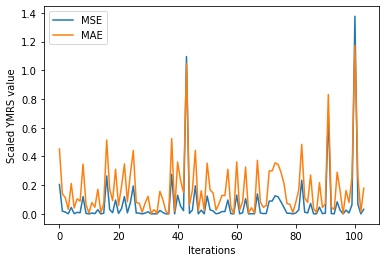

In [17]:
plt.xlabel("Iterations")
plt.ylabel("Scaled YMRS value")
plt.plot(train_loss, label="MSE")
plt.plot(train_mae, label="MAE")
plt.legend()
plt.show()

### Model evaluation  - validation set

Subset taken from test data is defined as a validation set.

In [18]:
x_val, y_val = x_test[:30], y_test[:30]

In [19]:
eval_loss = []
eval_mae = []
eval_index = 0

for input in x_val:
    input = reshape_X(input)
    scores = model.evaluate(input, y_val[eval_index], verbose = 0)
    
    eval_loss.append(scores[0])
    eval_mae.append(scores[1])
    
    eval_index += 1

In [20]:
avg_eval_loss = sum(eval_loss) / len(eval_loss)
avg_eval_mae = sum(eval_mae) / len(eval_mae)
print("Validation loss (avg):", avg_eval_loss, "Validation MAE (avg):", avg_eval_mae)

Validation loss (avg): 0.8667726815212518 Validation MAE (avg): 0.7923996195197105


In [21]:
real_eval_loss = round(float(scaler.inverse_transform(np.array(avg_eval_loss).reshape(-1,1))), 3)
real_eval_mae = round(float(scaler.inverse_transform(np.array(avg_eval_mae).reshape(-1,1))), 3)

print(f'AVG MSE: {real_eval_loss}')
print(f'AVG MAE: {real_eval_mae}')

AVG MSE: 24.435
AVG MAE: 23.607


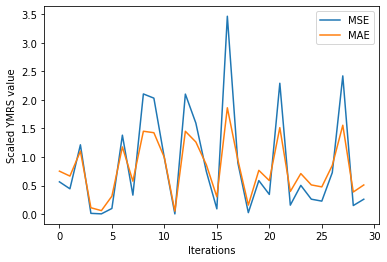

In [22]:
plt.xlabel("Iterations")
plt.ylabel("Scaled YMRS value")
plt.plot(eval_loss, label="MSE")
plt.plot(eval_mae, label="MAE")
plt.legend()
plt.show()

## Prediction

Prediction is made on different subset taken from the test dataset. Then actual and predicted YMRS values are compared.

In [23]:
x_pred, y_pred_actual = x_test[30:], y_test[30:]

In [24]:
y_prediction = []

pred_scores = []
pred_loss = []
pred_mae = []

pred_index = 0

for file in x_pred:
    file = np.array(file).reshape(1, file.shape[0], -1)
    pred_y = y_prediction.append(model.predict(file))
    
    scores = model.evaluate(file, y_pred_actual[pred_index], verbose=0)
    pred_scores.append(scores)
    pred_loss.append(scores[0])
    pred_mae.append(scores[1])
    
    pred_index += 1

### Model evaluation - prediction set

In [25]:
avg_pred_loss = sum(pred_loss) / len(pred_loss)
avg_pred_mae = sum(pred_mae) / len(pred_mae)
print("Prediction loss (avg):", avg_pred_loss, "Prediction MAE (avg):", avg_pred_mae)

Prediction loss (avg): 1.1652743007366857 Prediction MAE (avg): 0.9977534646789233


In [26]:
real_pred_loss = round(float(scaler.inverse_transform(np.array(avg_pred_loss).reshape(-1,1))), 3)
real_pred_mae = round(float(scaler.inverse_transform(np.array(avg_pred_mae).reshape(-1,1))), 3)

print(f'AVG MSE: {real_pred_loss}')
print(f'AVG MAE: {real_pred_mae}')

AVG MSE: 27.759
AVG MAE: 25.894


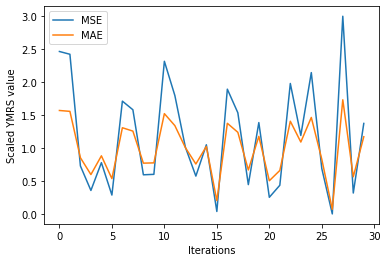

In [27]:
plt.xlabel("Iterations")
plt.ylabel("Scaled YMRS value")
plt.plot(pred_loss, label="MSE")
plt.plot(pred_mae, label="MAE")
plt.legend()
plt.show()

### Actual vs predicted comparison

In [28]:
y_prediction = np.array(y_prediction).reshape(-1, 1)
y_pred_actual = np.array(y_pred_actual).reshape(-1,1)

y_prediction = unscale_Y(y_prediction, scaler)
y_pred_actual = unscale_Y(y_pred_actual, scaler)

In [29]:
pred_df = pd.DataFrame(data=np.column_stack((y_pred_actual,y_prediction)),columns=['y_actual','y_pred'])
pred_df['pred_error'] = pred_df['y_actual'] - pred_df['y_pred']
pred_df = pred_df.sort_values(by=['y_actual']).reset_index()
pred_df['y_actual'] = pred_df['y_actual'].apply(np.int64)
pred_df

,index,y_actual,y_pred,pred_error
0,0,0,17.463762,-17.463762
1,1,0,17.314323,-17.314323
2,27,0,19.261677,-19.261677
3,22,0,15.654448,-15.654448
4,16,0,15.309143,-15.309143
5,6,0,14.559443,-14.559443
6,10,1,17.929913,-16.929913
7,29,2,15.045964,-13.045964
8,11,3,17.914438,-14.914438
9,17,3,16.791561,-13.791561


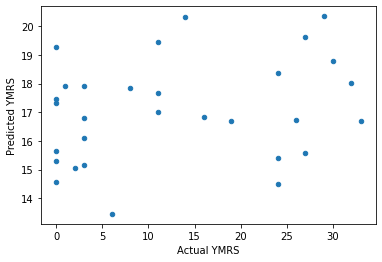

In [30]:
pred_df.plot('y_actual', 'y_pred', kind='scatter')
plt.xlabel("Actual YMRS")
plt.ylabel("Predicted YMRS")
plt.show()

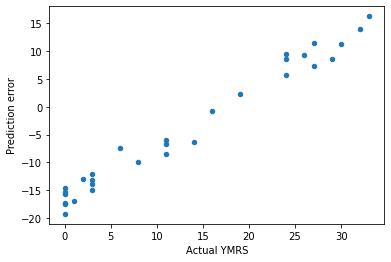

In [31]:
pred_df.plot('y_actual', 'pred_error', kind='scatter')
plt.xlabel("Actual YMRS")
plt.ylabel("Prediction error")
plt.show()

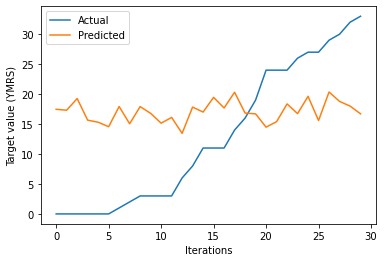

In [32]:
plt.xlabel("Iterations")
plt.ylabel("Target value (YMRS)")
plt.plot(pred_df['y_actual'], label="Actual")
plt.plot(pred_df['y_pred'], label="Predicted")
plt.legend()
plt.show()